In [2]:
# Clone of the CycleGAN repository
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git
%cd pytorch-CycleGAN-and-pix2pix

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2516, done.
remote: Total 2516 (delta 0), reused 0 (delta 0), pack-reused 2516 (from 1)
Receiving objects: 100% (2516/2516), 8.20 MiB | 17.53 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
/content/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix
Mounted at /content/drive


In [3]:
!mkdir -p /content/datasets/animeDS

!unzip -q '/content/drive/MyDrive/animeDS.zip' -d /content/datasets/animeDS/

import os

dataset_path = '/content/datasets/animeDS/dataset'
for subdir in ['trainA', 'trainB', 'testA', 'testB']:
    print(f"{subdir} exists:", os.path.exists(os.path.join(dataset_path, subdir)))


trainA exists: True
trainB exists: True
testA exists: True
testB exists: True


In [4]:
!unzip -l '/content/drive/MyDrive/animeDS.zip' | head -n 40


Archive:  /content/drive/MyDrive/animeDS.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
        0  2025-05-14 20:07   dataset/
        0  2025-05-14 20:07   dataset/testA/
    29680  2025-05-14 20:07   dataset/testA/female_10328.jpg
    31626  2025-05-14 20:07   dataset/testA/female_10500.jpg
    20071  2025-05-14 20:07   dataset/testA/female_11025.jpg
    20426  2025-05-14 20:07   dataset/testA/female_11464.jpg
    22776  2025-05-14 20:07   dataset/testA/female_11779.jpg
    18977  2025-05-14 20:07   dataset/testA/female_11846.jpg
    21794  2025-05-14 20:07   dataset/testA/female_11898.jpg
    17285  2025-05-14 20:07   dataset/testA/female_12323.jpg
    20380  2025-05-14 20:07   dataset/testA/female_12427.jpg
    31140  2025-05-14 20:07   dataset/testA/female_12552.jpg
    22614  2025-05-14 20:07   dataset/testA/female_12801.jpg
    18259  2025-05-14 20:07   dataset/testA/female_12855.jpg
    22275  2025-05-14 20:07   dataset/testA/female_12913.jpg
    1689

In [5]:
!pip install dominate


Training


In [ ]:
# First, remount Google Drive to ensure proper connection
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
print("Successfully remounted Google Drive")

# Import all necessary libraries
import os
import glob
import time
import torch
import numpy as np
from data import create_dataset
from models import create_model
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from types import SimpleNamespace
import sys
import shutil
from util.visualizer import save_images
from collections import deque

# Function to verify drive connection and remount if necessary
def ensure_drive_connected():
    try:
        test_path = '/content/drive/MyDrive'
        if not os.path.exists(test_path):
            print("Drive connection lost. Remounting...")
            from google.colab import drive
            drive.mount('/content/drive', force_remount=True)
            print("Drive remounted successfully")
        return True
    except:
        print("Failed to verify or remount drive. Will try to continue anyway.")
        return False

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01, monitor_metric='g_d_balance'):
        self.patience = patience
        self.min_delta = min_delta
        self.monitor_metric = monitor_metric
        self.best_score = None
        self.patience_counter = 0
        self.best_epoch = 0
        self.should_stop = False
        self.history = deque(maxlen=10)  # Keep track of last 10 epochs

    def __call__(self, current_score, epoch):
        self.history.append(current_score)

        # For G/D balance, we want it to be close to 1-5 (ideal range)
        if self.monitor_metric == 'g_d_balance':
            # Convert to a score where closer to 3 is better (3 is ideal balance)
            score = -abs(current_score - 3.0)  # Negative because we want to maximize closeness to 3
        else:
            score = -current_score  # For losses, lower is better

        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
        elif score > self.best_score + self.min_delta:
            # Improvement found
            self.best_score = score
            self.best_epoch = epoch
            self.patience_counter = 0
            print(f"📈 Improvement found at epoch {epoch}, resetting patience counter")
        else:
            self.patience_counter += 1
            print(f"⏳ No improvement for {self.patience_counter} epochs (patience: {self.patience})")

        if self.patience_counter >= self.patience:
            print(f"🛑 Early stopping triggered! Best epoch was {self.best_epoch}")
            self.should_stop = True

        return self.should_stop

# Improved logging with better loss tracking
class RobustLogger:
    def __init__(self, drive_path, local_path):
        self.drive_path = drive_path
        self.local_path = local_path
        self.drive_log_file = None
        self.local_log_file = None
        self.buffer = []
        self.last_flush_time = time.time()
        self.flush_interval = 300

        os.makedirs(os.path.dirname(local_path), exist_ok=True)

        try:
            if ensure_drive_connected():
                self.drive_log_file = open(drive_path, 'a')
                print(f"Successfully opened log file at {drive_path}")
        except Exception as e:
            print(f"Could not open drive log file: {e}")

        try:
            self.local_log_file = open(local_path, 'a')
            print(f"Successfully opened local log file at {local_path}")
        except Exception as e:
            print(f"Could not open local log file: {e}")
            try:
                tmp_path = '/tmp/loss_log.txt'
                self.local_log_file = open(tmp_path, 'a')
                print(f"Using temporary log file at {tmp_path}")
            except:
                print("WARNING: Could not open any log file!")

    def write(self, message):
        self.buffer.append(message)

        if self.local_log_file:
            try:
                self.local_log_file.write(message)
                self.local_log_file.flush()
            except Exception as e:
                print(f"Error writing to local log: {e}")

        current_time = time.time()
        if self.drive_log_file and (current_time - self.last_flush_time > self.flush_interval):
            self.flush_to_drive()
            self.last_flush_time = current_time

    def flush_to_drive(self):
        if not self.drive_log_file:
            return
        try:
            if ensure_drive_connected():
                try:
                    self.drive_log_file.close()
                except:
                    pass
                time.sleep(1)
                self.drive_log_file = open(self.drive_path, 'a')
                for message in self.buffer:
                    self.drive_log_file.write(message)
                self.drive_log_file.flush()
                self.buffer = []
                print("Successfully flushed logs to Drive")
        except Exception as e:
            print(f"Failed to flush logs to Drive: {e}")

    def close(self):
        try:
            self.flush_to_drive()
        except:
            print("Failed final flush to drive")
        if self.drive_log_file:
            try:
                self.drive_log_file.close()
            except:
                pass
        if self.local_log_file:
            try:
                self.local_log_file.close()
            except:
                pass

# Function to safely save checkpoints
def safe_save_networks(model, suffix, model_save_dir, local_backup_dir):
    os.makedirs(model_save_dir, exist_ok=True)
    os.makedirs(local_backup_dir, exist_ok=True)

    success = False
    max_retries = 3
    retry_delay = 5

    if ensure_drive_connected():
        for attempt in range(max_retries):
            try:
                model.save_networks(suffix)
                print(f"Successfully saved checkpoint {suffix} to Drive")
                success = True
                break
            except OSError as e:
                print(f"Attempt {attempt+1}/{max_retries}: Error saving networks: {e}")
                if attempt < max_retries - 1:
                    print(f"Waiting {retry_delay} seconds before retry...")
                    time.sleep(retry_delay)
                    print("Retrying save operation...")

    if not success:
        print("Drive save failed, creating local backup...")
        try:
            local_gen_path = os.path.join(local_backup_dir, f'{suffix}_net_G_A.pth')
            local_disc_path = os.path.join(local_backup_dir, f'{suffix}_net_D_A.pth')
            torch.save(model.netG_A.state_dict(), local_gen_path)
            torch.save(model.netD_A.state_dict(), local_disc_path)
            print(f"Successfully saved local backup for {suffix}")
            return True
        except Exception as e:
            print(f"Even local backup failed: {e}")
            return False

    return success

# Function to safely load model
def safe_load_model(opt):
    max_retries = 3
    for attempt in range(max_retries):
        try:
            print(f"Attempt {attempt+1}/{max_retries}: Creating and loading model...")
            model = create_model(opt)
            model.setup(opt)
            print(f"Successfully created model and loaded checkpoint")
            return model
        except Exception as e:
            print(f"Error loading model: {e}")
            if attempt < max_retries - 1:
                print("Waiting before retry...")
                time.sleep(5)
                print("Retrying model loading...")
                ensure_drive_connected()
            else:
                print("All model loading attempts failed!")
                raise

def tensor2im(input_image, imtype=np.uint8):
    if isinstance(input_image, torch.Tensor):
        image_tensor = input_image.detach()
    else:
        return input_image
    image_numpy = image_tensor[0].cpu().float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    return image_numpy.astype(imtype)

def save_results(epoch, real_A, fake_B, outputs_dir, local_outputs_dir, total_target_epochs=120):
    os.makedirs(local_outputs_dir, exist_ok=True)

    real_A_img = tensor2im(real_A)
    fake_B_img = tensor2im(fake_B)

    local_path_input = os.path.join(local_outputs_dir, f'epoch_{epoch}_input.png')
    local_path_output = os.path.join(local_outputs_dir, f'epoch_{epoch}_output.png')

    Image.fromarray(real_A_img).save(local_path_input)
    Image.fromarray(fake_B_img).save(local_path_output)
    print(f"Saved local output images to {local_outputs_dir}")

    if epoch % 5 == 0 or epoch % 10 == 0 or epoch % 25 == 0 or epoch >= 115 or epoch == total_target_epochs:
        if ensure_drive_connected():
            try:
                os.makedirs(outputs_dir, exist_ok=True)

                drive_path_output = os.path.join(outputs_dir, f'epoch_{epoch}.png')
                Image.fromarray(fake_B_img).save(drive_path_output)

                drive_path_combined = os.path.join(outputs_dir, f'combined_epoch_{epoch}.png')

                width = real_A_img.shape[1] * 2
                height = real_A_img.shape[0]
                combined_img = np.zeros((height, width, 3), dtype=np.uint8)

                combined_img[:, :real_A_img.shape[1], :] = real_A_img
                combined_img[:, real_A_img.shape[1]:, :] = fake_B_img

                Image.fromarray(combined_img).save(drive_path_combined)

                print(f"Saved output images to Drive at {outputs_dir}")
            except Exception as e:
                print(f"Failed to save image to Drive: {e}")

def get_last_completed_epoch(log_dir, default_start=1):
    progress_file = os.path.join(log_dir, 'last_completed_epoch.txt')
    local_progress_file = '/content/last_completed_epoch.txt'

    if os.path.exists(progress_file):
        try:
            with open(progress_file, 'r') as f:
                epoch = int(f.read().strip())
                print(f"Found progress file on Drive: last completed epoch {epoch}")
                return epoch
        except:
            print("Could not read Drive progress file")

    if os.path.exists(local_progress_file):
        try:
            with open(local_progress_file, 'r') as f:
                epoch = int(f.read().strip())
                print(f"Found local progress file: last completed epoch {epoch}")
                return epoch
        except:
            print("Could not read local progress file")

    if os.path.exists('/content/drive/MyDrive/finalProject_epoch_outputs'):
        try:
            files = glob.glob('/content/drive/MyDrive/finalProject_epoch_outputs/epoch_*.png')
            if files:
                epochs = []
                for f in files:
                    try:
                        epoch = int(os.path.basename(f).replace('epoch_', '').replace('.png', ''))
                        epochs.append(epoch)
                    except:
                        pass
                if epochs:
                    latest = max(epochs)
                    print(f"Inferred progress from output images: last completed epoch {latest}")
                    return latest
        except:
            print("Could not infer progress from output images")

    return default_start

# Main training function with early stopping and better learning rates
def train_anime_style_transfer(total_target_epochs=120, min_learning_rate=5e-5):
    ensure_drive_connected()

    model_name = 'anime_style_transfer'
    checkpoints_dir = '/content/drive/MyDrive/finalProject_checkpoints'
    model_dir = os.path.join(checkpoints_dir, model_name)

    log_dir = '/content/drive/MyDrive/finalProject_logs'
    outputs_dir = '/content/drive/MyDrive/finalProject_epoch_outputs'

    local_log_dir = '/content/backup_logs'
    local_outputs_dir = '/content/backup_outputs'
    local_checkpoints_dir = '/content/backup_checkpoints'

    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(outputs_dir, exist_ok=True)
    os.makedirs(local_log_dir, exist_ok=True)
    os.makedirs(local_outputs_dir, exist_ok=True)
    os.makedirs(local_checkpoints_dir, exist_ok=True)

    print(f"Using directories: {log_dir}, {outputs_dir}, {model_dir}")
    print(f"Backup directories: {local_log_dir}, {local_outputs_dir}, {local_checkpoints_dir}")

    # Check for checkpoint files
    print("Looking for checkpoints in:", model_dir)
    start_epoch = 1

    if os.path.exists(model_dir):
        checkpoint_files = [f for f in os.listdir(model_dir) if f.endswith('.pth') and f[0].isdigit()]
        if checkpoint_files:
            numeric_prefixes = []
            for f in checkpoint_files:
                prefix = f.split('_')[0]
                if prefix.isdigit():
                    numeric_prefixes.append(int(prefix))

            if numeric_prefixes:
                latest_epoch = max(numeric_prefixes)
                start_epoch = latest_epoch + 1
                print(f"✓ Found checkpoint for epoch {latest_epoch}, will continue from epoch {start_epoch}")

    last_completed = get_last_completed_epoch(log_dir, default_start=start_epoch)
    if last_completed >= start_epoch:
        print(f"Progress tracking indicates epoch {last_completed} was completed")
        start_epoch = last_completed + 1
        print(f"Adjusted start epoch to {start_epoch}")

    if start_epoch > total_target_epochs:
        print(f"🎉 Training already completed ({start_epoch-1} epochs)!")
        return "Training already completed!"

    remaining_epochs = total_target_epochs - start_epoch + 1

    # IMPROVED: Better learning rate strategy for 110-120
    if start_epoch >= 110:
        print("Fine-tuning phase (110-120): Using conservative learning rates")
        base_gen_lr = 0.00008   # Slightly lower than before
        base_disc_lr = 0.00004  # Slightly higher than before
        print(f"Generator LR: {base_gen_lr}, Discriminator LR: {base_disc_lr}")
    elif start_epoch >= 100:
        print("Extended phase (100-110): Using balanced learning rates")
        base_gen_lr = 0.0001
        base_disc_lr = 0.00005
    else:
        base_gen_lr = 0.0002
        base_disc_lr = 0.0002

    # Better identity preservation for fine-tuning
    lambda_identity = 0.8 if start_epoch >= 110 else 1.0

    # Define options
    opt = SimpleNamespace(
        dataroot='/content/datasets/animeDS/dataset',
        name=model_name,
        model='cycle_gan',
        dataset_mode='unaligned',
        phase='train',
        netG='resnet_9blocks',
        netD='basic',
        n_epochs=total_target_epochs,
        n_epochs_decay=0,
        lambda_A=10.0,
        lambda_B=10.0,
        lambda_identity=lambda_identity,
        display_id=0,
        no_html=True,
        batch_size=1,
        num_threads=4,
        serial_batches=False,
        checkpoints_dir=checkpoints_dir,
        input_nc=3,
        output_nc=3,
        preprocess='resize_and_crop',
        load_size=286,
        crop_size=256,
        max_dataset_size=float("inf"),
        gpu_ids=[0] if torch.cuda.is_available() else [],
        isTrain=True,
        epoch='latest',
        load_iter=0,
        verbose=False,
        suffix='',
        direction='AtoB',
        continue_train=True if start_epoch > 1 else False,
        epoch_count=start_epoch,
        niter=total_target_epochs,
        niter_decay=0,
        beta1=0.5,
        lr=base_gen_lr,
        no_flip=False,
        display_freq=3400,
        display_ncols=4,
        display_env='main',
        display_port=8097,
        update_html_freq=1000,
        print_freq=400,
        save_latest_freq=3400,
        save_epoch_freq=1,
        save_by_iter=False,
        no_lsgan=False,
        norm='instance',
        init_type='normal',
        init_gain=0.02,
        no_dropout=True,
        pool_size=50,
        gan_mode='lsgan',
        lr_policy='linear',
        lr_decay_iters=3,
        display_winsize=256,
        ngf=64,
        ndf=64,
        n_layers_D=3
    )

    dataset_path = '/content/datasets/animeDS/dataset'
    if not os.path.exists(dataset_path):
        print(f"Dataset not found at {dataset_path}. Extracting from Drive...")
        !unzip -q '/content/drive/MyDrive/animeDS.zip' -d /content/datasets/animeDS/

    drive_log_path = os.path.join(log_dir, 'loss_log.txt')
    local_log_path = os.path.join(local_log_dir, 'loss_log.txt')
    logger = RobustLogger(drive_log_path, local_log_path)

    print("Initializing dataset...")
    dataset = create_dataset(opt)
    dataset_size = len(dataset)
    print('Number of training images = %d' % dataset_size)

    print("Creating model...")
    model = safe_load_model(opt)
    print(f"Model created successfully. Continuing from epoch {start_epoch}")

    # Load test image for visualization
    test_image_path = os.path.join(opt.dataroot, 'testA')
    if os.path.exists(test_image_path) and len(os.listdir(test_image_path)) > 0:
        sample_img_name = os.listdir(test_image_path)[0]
        img_path = os.path.join(test_image_path, sample_img_name)
        print(f"Using test image: {img_path}")
        img = Image.open(img_path).convert('RGB')
        transform = transforms.Compose([
            transforms.Resize((opt.crop_size, opt.crop_size), transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        fixed_input = transform(img).unsqueeze(0)
        if len(opt.gpu_ids) > 0:
            fixed_input = fixed_input.cuda(opt.gpu_ids[0])
    else:
        print("Error: No test images found!")
        sys.exit(1)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=5, min_delta=0.02, monitor_metric='g_d_balance')

    # Log training session start
    info_line = f"\n\n# EARLY STOPPING TRAINING: Starting from epoch {start_epoch}, target {total_target_epochs}\n"
    info_line += f"# FINE-TUNED LEARNING RATES: Generator={base_gen_lr}, Discriminator={base_disc_lr}\n"
    info_line += f"# EARLY STOPPING: Patience=5, monitoring G/D balance\n"
    logger.write(info_line)

    # Training loop with early stopping
    total_iters = 0
    print(f"Starting fine-tuned training for {remaining_epochs} more epochs from epoch {start_epoch} to {total_target_epochs}...")

    try:
        for epoch in range(start_epoch, total_target_epochs + 1):
            with open('/content/current_epoch.txt', 'w') as f:
                f.write(str(epoch))

            epoch_start_time = time.time()
            epoch_iter = 0

            ensure_drive_connected()

            # Set learning rates
            for optimizer_idx, optimizer in enumerate(model.optimizers):
                for param_group in optimizer.param_groups:
                    if optimizer_idx == 0 or optimizer_idx == 2:  # Generator optimizers
                        param_group['lr'] = base_gen_lr
                    else:  # Discriminator optimizers
                        param_group['lr'] = base_disc_lr

            gen_lr = model.optimizers[0].param_groups[0]['lr']
            disc_lr = model.optimizers[1].param_groups[0]['lr']
            print(f"Epoch {epoch} learning rates = Generator: {gen_lr:.7f}, Discriminator: {disc_lr:.7f}")

            # Track losses for early stopping
            epoch_losses = {'G_A': [], 'G_B': [], 'D_A': [], 'D_B': [], 'cycle_A': [], 'cycle_B': []}

            for i, data in enumerate(dataset):
                total_iters += opt.batch_size
                epoch_iter += opt.batch_size

                model.set_input(data)
                model.optimize_parameters()

                if total_iters % opt.print_freq == 0:
                    losses = model.get_current_losses()

                    log_components = [f"{epoch}", f"{total_iters}"]
                    for loss_key in ['G_A', 'G_L1', 'cycle_A', 'idt_A', 'D_A', 'D_B', 'G_B', 'cycle_B', 'idt_B']:
                        log_components.append(f"{losses.get(loss_key, 0):.4f}")

                    log_line = ",".join(log_components) + "\n"
                    logger.write(log_line)

                    # Track for early stopping
                    for k, v in losses.items():
                        if k in epoch_losses:
                            epoch_losses[k].append(v)

                    print(f'Epoch {epoch} | Iter {epoch_iter}/{dataset_size} | ' +
                          ' | '.join([f"{k}: {v:.3f}" for k, v in losses.items()]))

            # Calculate epoch averages
            epoch_avg_losses = {}
            for k, v in epoch_losses.items():
                if v:
                    epoch_avg_losses[k] = sum(v) / len(v)

            # Calculate G/D balance for early stopping
            if 'G_A' in epoch_avg_losses and 'D_A' in epoch_avg_losses:
                g_avg = (epoch_avg_losses.get('G_A', 0) + epoch_avg_losses.get('G_B', 0)) / 2
                d_avg = (epoch_avg_losses.get('D_A', 0) + epoch_avg_losses.get('D_B', 0)) / 2
                g_d_balance = g_avg / d_avg if d_avg > 0 else float('inf')

                print(f"Epoch {epoch} G/D balance: {g_d_balance:.2f}")

                # Check early stopping
                should_stop = early_stopping(g_d_balance, epoch)
                if should_stop:
                    print(f"🛑 Early stopping triggered at epoch {epoch}!")
                    print(f"Best model was at epoch {early_stopping.best_epoch}")
                    break

            print(f'\nEnd of epoch {epoch} / {total_target_epochs}')
            print(f'Time taken: {time.time() - epoch_start_time:.2f}s')

            # Generate and save test image
            with torch.no_grad():
                test_data = {
                    'A': fixed_input,
                    'B': torch.zeros_like(fixed_input),
                    'A_paths': ['test_image'],
                    'B_paths': ['test_image']
                }
                model.set_input(test_data)
                model.test()

                visuals = model.get_current_visuals()
                real_A = visuals['real_A']
                fake_B = visuals['fake_B']

                save_results(epoch, real_A, fake_B, outputs_dir, local_outputs_dir, total_target_epochs)

            # Save model checkpoint
            print(f'Saving the model at the end of epoch {epoch}')
            model_save_dir = os.path.join(opt.checkpoints_dir, opt.name)

            safe_save_networks(model, 'latest', model_save_dir, local_checkpoints_dir)
            safe_save_networks(model, epoch, model_save_dir, local_checkpoints_dir)

            # Write completion marker
            try:
                with open(os.path.join(log_dir, 'last_completed_epoch.txt'), 'w') as f:
                    f.write(str(epoch))
            except:
                with open('/content/last_completed_epoch.txt', 'w') as f:
                    f.write(str(epoch))

            try:
                logger.flush_to_drive()
            except:
                print("Failed to flush logs to Drive")

            if epoch % 5 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()

    except KeyboardInterrupt:
        print("\nTraining interrupted by user!")

    except Exception as e:
        print(f"Error during training: {e}")
        try:
            ensure_drive_connected()
            safe_save_networks(model, 'latest', model_save_dir, local_checkpoints_dir)
            safe_save_networks(model, f"error_{epoch}", model_save_dir, local_checkpoints_dir)
        except:
            print("Could not save checkpoint after error")

    finally:
        logger.close()
        print("Training ended - resources cleaned up")

        if early_stopping.should_stop:
            print(f"📊 Training stopped early at epoch {epoch}")
            print(f"🏆 Best epoch: {early_stopping.best_epoch}")
            print(f"💡 Consider using the model from epoch {early_stopping.best_epoch} for best results")

    return "Training completed or stopped early"

# Run the improved training with early stopping
train_anime_style_transfer(total_target_epochs=120, min_learning_rate=5e-5)

Mounted at /content/drive
Successfully remounted Google Drive
Using directories: /content/drive/MyDrive/finalProject_logs, /content/drive/MyDrive/finalProject_epoch_outputs, /content/drive/MyDrive/finalProject_checkpoints/anime_style_transfer
Backup directories: /content/backup_logs, /content/backup_outputs, /content/backup_checkpoints
Looking for checkpoints in: /content/drive/MyDrive/finalProject_checkpoints/anime_style_transfer
✓ Found checkpoint for epoch 110, will continue from epoch 111
Found progress file on Drive: last completed epoch 110
Fine-tuning phase (110-120): Using conservative learning rates
Generator LR: 8e-05, Discriminator LR: 4e-05
Successfully opened log file at /content/drive/MyDrive/finalProject_logs/loss_log.txt
Successfully opened local log file at /content/backup_logs/loss_log.txt
Initializing dataset...
dataset [UnalignedDataset] was created
Number of training images = 3400
Creating model...
Attempt 1/3: Creating and loading model...
initialize network with 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


initialize network with normal
initialize network with normal
initialize network with normal
model [CycleGANModel] was created
loading the model from /content/drive/MyDrive/finalProject_checkpoints/anime_style_transfer/latest_net_G_A.pth
loading the model from /content/drive/MyDrive/finalProject_checkpoints/anime_style_transfer/latest_net_G_B.pth
loading the model from /content/drive/MyDrive/finalProject_checkpoints/anime_style_transfer/latest_net_D_A.pth
loading the model from /content/drive/MyDrive/finalProject_checkpoints/anime_style_transfer/latest_net_D_B.pth
---------- Networks initialized -------------
[Network G_A] Total number of parameters : 11.378 M
[Network G_B] Total number of parameters : 11.378 M
[Network D_A] Total number of parameters : 2.765 M
[Network D_B] Total number of parameters : 2.765 M
-----------------------------------------------
Successfully created model and loaded checkpoint
Model created successfully. Continuing from epoch 111
Using test image: /content

'Training completed or stopped early'

In [ ]:
# Continue training from epoch 120+ with early stopping (clean version)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
print("Successfully remounted Google Drive")

# Import all necessary libraries
import os
import glob
import time
import torch
import numpy as np
from data import create_dataset
from models import create_model
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from types import SimpleNamespace
import sys
import shutil
from util.visualizer import save_images
from collections import deque
from IPython.display import display, Javascript, clear_output

# Keep Colab alive function
def keep_colab_alive():
    """Keeps Colab from disconnecting by simulating activity"""
    display(Javascript("""
    function ClickConnect(){
        console.log("Keeping Colab connected...");
        document.querySelector("colab-toolbar-button#connect").click()
    }
    setInterval(ClickConnect, 60000);
    """))
    print("Anti-disconnect mechanism activated")

# Activate keep-alive immediately
keep_colab_alive()

# Function to verify drive connection and remount if necessary
def ensure_drive_connected():
    try:
        test_path = '/content/drive/MyDrive'
        if not os.path.exists(test_path):
            print("Drive connection lost. Remounting...")
            drive.mount('/content/drive', force_remount=True)
            time.sleep(2)
            print("Drive remounted successfully")
        return True
    except Exception as e:
        print(f"Failed to verify or remount drive: {e}")
        return False

# Enhanced Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01, monitor_metric='g_d_balance'):
        self.patience = patience
        self.min_delta = min_delta
        self.monitor_metric = monitor_metric
        self.best_score = None
        self.patience_counter = 0
        self.best_epoch = 0
        self.should_stop = False
        self.history = deque(maxlen=10)  # Keep track of last 10 epochs

    def __call__(self, current_score, epoch):
        self.history.append(current_score)

        # For G/D balance, we want it to be close to 2-4 (ideal range)
        if self.monitor_metric == 'g_d_balance':
            # Convert to a score where closer to 3 is better
            if 1.5 <= current_score <= 5.0:  # Acceptable range
                score = -abs(current_score - 3.0)  # Closer to 3 is better
            else:
                score = -10.0  # Heavily penalize values outside acceptable range
        else:
            score = -current_score  # For losses, lower is better

        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
            print(f"Initial best score set: {score:.4f} at epoch {epoch}")
        elif score > self.best_score + self.min_delta:
            # Improvement found
            improvement = score - self.best_score
            self.best_score = score
            self.best_epoch = epoch
            self.patience_counter = 0
            print(f"Improvement found at epoch {epoch}! Score improved by {improvement:.4f}")
            print(f"Patience counter reset to 0")
        else:
            self.patience_counter += 1
            print(f"No improvement for {self.patience_counter}/{self.patience} epochs")
            if self.patience_counter >= self.patience:
                print(f"EARLY STOPPING TRIGGERED!")
                print(f"Best performance was at epoch {self.best_epoch}")
                self.should_stop = True

        return self.should_stop

# Robust Logger with better error handling
class RobustLogger:
    def __init__(self, drive_path, local_path):
        self.drive_path = drive_path
        self.local_path = local_path
        self.drive_log_file = None
        self.local_log_file = None
        self.buffer = []
        self.last_flush_time = time.time()
        self.flush_interval = 180  # Flush every 3 minutes

        # Ensure local directory exists
        os.makedirs(os.path.dirname(local_path), exist_ok=True)

        # Try to open drive log file
        try:
            if ensure_drive_connected():
                os.makedirs(os.path.dirname(drive_path), exist_ok=True)
                self.drive_log_file = open(drive_path, 'a')
                print(f"Opened Drive log file: {drive_path}")
        except Exception as e:
            print(f"Could not open Drive log file: {e}")

        # Always open local log file as backup
        try:
            self.local_log_file = open(local_path, 'a')
            print(f"Opened local log file: {local_path}")
        except Exception as e:
            print(f"Could not open local log file: {e}")

    def write(self, message):
        timestamp = time.strftime("%H:%M:%S")
        timestamped_message = f"[{timestamp}] {message}" if not message.startswith('#') and not message.startswith('epoch') else message

        self.buffer.append(timestamped_message)

        # Always write to local file immediately
        if self.local_log_file:
            try:
                self.local_log_file.write(timestamped_message)
                self.local_log_file.flush()
            except Exception as e:
                print(f"Error writing to local log: {e}")

        # Periodically flush to drive
        current_time = time.time()
        if current_time - self.last_flush_time > self.flush_interval:
            self.flush_to_drive()
            self.last_flush_time = current_time

    def flush_to_drive(self):
        if not self.drive_log_file or not self.buffer:
            return
        try:
            if ensure_drive_connected():
                for message in self.buffer:
                    self.drive_log_file.write(message)
                self.drive_log_file.flush()
                self.buffer = []
                print("Successfully flushed logs to Drive")
        except Exception as e:
            print(f"Failed to flush logs to Drive: {e}")

    def close(self):
        try:
            self.flush_to_drive()
        except:
            print("Failed final flush to drive")

        if self.drive_log_file:
            try:
                self.drive_log_file.close()
            except:
                pass
        if self.local_log_file:
            try:
                self.local_log_file.close()
            except:
                pass

# Function to safely save checkpoints with retries
def safe_save_networks(model, suffix, model_save_dir, local_backup_dir):
    """Save networks with error handling and local backup"""
    os.makedirs(model_save_dir, exist_ok=True)
    os.makedirs(local_backup_dir, exist_ok=True)

    success = False
    max_retries = 3
    retry_delay = 5

    # Try to save to Drive first
    if ensure_drive_connected():
        for attempt in range(max_retries):
            try:
                model.save_networks(suffix)
                print(f"Successfully saved checkpoint {suffix} to Drive")
                success = True
                break
            except Exception as e:
                print(f"Attempt {attempt+1}/{max_retries} failed: {e}")
                if attempt < max_retries - 1:
                    print(f"Waiting {retry_delay} seconds before retry...")
                    time.sleep(retry_delay)
                    ensure_drive_connected()

    # Always create local backup regardless of Drive success
    try:
        local_model_dir = os.path.join(local_backup_dir, 'anime_style_transfer')
        os.makedirs(local_model_dir, exist_ok=True)

        # Save generator and discriminator state dicts
        torch.save(model.netG_A.state_dict(), os.path.join(local_model_dir, f'{suffix}_net_G_A.pth'))
        torch.save(model.netD_A.state_dict(), os.path.join(local_model_dir, f'{suffix}_net_D_A.pth'))
        torch.save(model.netG_B.state_dict(), os.path.join(local_model_dir, f'{suffix}_net_G_B.pth'))
        torch.save(model.netD_B.state_dict(), os.path.join(local_model_dir, f'{suffix}_net_D_B.pth'))
        print(f"Created local backup for {suffix}")
    except Exception as e:
        print(f"Local backup failed: {e}")

    return success

# Function to detect latest checkpoint
def find_latest_checkpoint(model_dir):
    """Find the latest checkpoint epoch"""
    start_epoch = 1

    if not os.path.exists(model_dir):
        print(f"Model directory not found: {model_dir}")
        return start_epoch

    try:
        all_files = sorted(os.listdir(model_dir))
        print(f"Found {len(all_files)} files in checkpoint directory")

        # Look for numbered checkpoint files
        generator_files = [f for f in all_files if 'net_G_A' in f and not f.startswith('latest_')]
        print(f"Found {len(generator_files)} generator checkpoints")

        if len(generator_files) > 0:
            print(f"Sample files: {generator_files[:5]}")  # Show first 5 files

        # Extract epoch numbers
        numeric_epochs = []
        for f in generator_files:
            try:
                # Extract number from filename (e.g., "120_net_G_A.pth" -> 120)
                prefix = f.split('_')[0]
                if prefix.isdigit():
                    numeric_epochs.append(int(prefix))
            except:
                continue

        if numeric_epochs:
            latest_epoch = max(numeric_epochs)
            start_epoch = latest_epoch + 1
            print(f"Found checkpoint for epoch {latest_epoch}")
            print(f"Will continue from epoch {start_epoch}")
        else:
            print("No numbered checkpoints found, starting from epoch 1")

    except Exception as e:
        print(f"Error checking checkpoints: {e}")

    return start_epoch

def tensor2im(input_image, imtype=np.uint8):
    """Convert tensor to numpy image"""
    if isinstance(input_image, torch.Tensor):
        image_tensor = input_image.detach()
    else:
        return input_image
    image_numpy = image_tensor[0].cpu().float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    return image_numpy.astype(imtype)

def save_results(epoch, real_A, fake_B, outputs_dir, local_outputs_dir):
    """Save visualization results with error handling"""
    os.makedirs(local_outputs_dir, exist_ok=True)

    try:
        real_A_img = tensor2im(real_A)
        fake_B_img = tensor2im(fake_B)

        # Always save locally
        local_path = os.path.join(local_outputs_dir, f'epoch_{epoch}.png')
        Image.fromarray(fake_B_img).save(local_path)
        print(f"Saved local output: epoch_{epoch}.png")

        # Save to Drive every 5 epochs or important milestones
        if epoch % 5 == 0 or epoch % 10 == 0:
            if ensure_drive_connected():
                try:
                    os.makedirs(outputs_dir, exist_ok=True)

                    # Save individual output
                    drive_path = os.path.join(outputs_dir, f'epoch_{epoch}.png')
                    Image.fromarray(fake_B_img).save(drive_path)

                    # Save combined image (input + output)
                    combined_path = os.path.join(outputs_dir, f'combined_epoch_{epoch}.png')
                    width = real_A_img.shape[1] * 2
                    height = real_A_img.shape[0]
                    combined_img = np.zeros((height, width, 3), dtype=np.uint8)
                    combined_img[:, :real_A_img.shape[1], :] = real_A_img
                    combined_img[:, real_A_img.shape[1]:, :] = fake_B_img
                    Image.fromarray(combined_img).save(combined_path)

                    print(f"Saved to Drive: epoch_{epoch}.png")
                except Exception as e:
                    print(f"Failed to save to Drive: {e}")
    except Exception as e:
        print(f"Error saving results: {e}")

# Main training function with early stopping
def continue_training_with_early_stopping():
    """Continue training from current checkpoint with early stopping"""

    print("STARTING CONTINUOUS TRAINING WITH EARLY STOPPING")
    print("=" * 60)

    # Setup directories
    model_name = 'anime_style_transfer'
    checkpoints_dir = '/content/drive/MyDrive/finalProject_checkpoints'
    model_dir = os.path.join(checkpoints_dir, model_name)
    log_dir = '/content/drive/MyDrive/finalProject_logs'
    outputs_dir = '/content/drive/MyDrive/finalProject_epoch_outputs'

    # Local backup directories
    local_log_dir = '/content/backup_logs'
    local_outputs_dir = '/content/backup_outputs'
    local_checkpoints_dir = '/content/backup_checkpoints'

    # Create directories
    for directory in [log_dir, outputs_dir, local_log_dir, local_outputs_dir, local_checkpoints_dir]:
        os.makedirs(directory, exist_ok=True)

    # Find the latest checkpoint
    start_epoch = find_latest_checkpoint(model_dir)

    print(f"\nTRAINING CONFIGURATION:")
    print(f"  Starting from epoch: {start_epoch}")
    print(f"  Early stopping patience: 5 epochs")
    print(f"  Monitoring metric: G/D balance")
    print(f"  Checkpoint frequency: Every epoch")
    print(f"  Visualization frequency: Every 5 epochs")
    print(f"  Print frequency: Every 400 iterations")

    # Continue your original linear decay schedule but with better minimum rates
    # Your original setup: 50 regular epochs + 50 decay epochs = 100 total
    # At epoch 120, you're 20 epochs into extended training
    original_n_epochs = 50
    original_n_epochs_decay = 50
    original_total = original_n_epochs + original_n_epochs_decay  # 100

    # Your actual learning rates at epoch 120 were working well
    current_gen_lr = 0.00008   # From your epoch 120 log
    current_disc_lr = 0.00004  # From your epoch 120 log

    print(f"  Your epoch 120 rates: Gen={current_gen_lr}, Disc={current_disc_lr}")
    print(f"  These rates were producing results, so let's improve on them")

    # Strategy: Start slightly higher than your epoch 120 rates to make better progress
    # but still conservative enough to not break quality
    base_gen_lr = 0.00010    # Slightly higher than your 0.00008
    base_disc_lr = 0.00005   # Slightly higher than your 0.00004
    lambda_identity = 0.5    # Keep original identity weight

    print(f"  New improved rates:")
    print(f"  Generator LR: {base_gen_lr} (was {current_gen_lr})")
    print(f"  Discriminator LR: {base_disc_lr} (was {current_disc_lr})")
    print(f"  Identity weight: {lambda_identity}")
    print(f"\nWhy these rates:")
    print(f"  - Slightly higher than epoch 120 for better progress")
    print(f"  - Still conservative to preserve quality")
    print(f"  - Should make noticeable improvements")
    print(f"  - Linear decay will continue reducing them gradually")

    # Setup model options
    opt = SimpleNamespace(
        dataroot='/content/datasets/animeDS/dataset',
        name=model_name,
        model='cycle_gan',
        dataset_mode='unaligned',
        phase='train',
        netG='resnet_9blocks',
        netD='basic',
        n_epochs=300,  # High number, early stopping will control actual end
        n_epochs_decay=300,  # Enable decay to continue
        lambda_A=10.0,
        lambda_B=10.0,
        lambda_identity=lambda_identity,
        display_id=0,
        no_html=True,
        batch_size=1,
        num_threads=2,  # Reduced for stability
        serial_batches=False,
        checkpoints_dir=checkpoints_dir,
        input_nc=3,
        output_nc=3,
        preprocess='resize_and_crop',
        load_size=286,
        crop_size=256,
        max_dataset_size=float("inf"),
        gpu_ids=[0] if torch.cuda.is_available() else [],
        isTrain=True,
        epoch='latest',
        load_iter=0,
        verbose=False,
        suffix='',
        direction='AtoB',
        continue_train=True if start_epoch > 1 else False,
        epoch_count=start_epoch,
        niter=300,
        niter_decay=0,
        beta1=0.5,
        lr=base_gen_lr,
        no_flip=False,
        display_freq=3400,
        display_ncols=4,
        display_env='main',
        display_port=8097,
        update_html_freq=1000,
        print_freq=400,  # Print every 400 iterations (same as your current training)
        save_latest_freq=3400,
        save_epoch_freq=1,
        save_by_iter=False,
        no_lsgan=False,
        norm='instance',
        init_type='normal',
        init_gain=0.02,
        no_dropout=True,
        pool_size=50,
        gan_mode='lsgan',
        lr_policy='linear',  # Continue linear decay like your original training
        lr_decay_iters=3,
        display_winsize=256,
        ngf=64,
        ndf=64,
        n_layers_D=3
    )

    # Check dataset
    dataset_path = '/content/datasets/animeDS/dataset'
    if not os.path.exists(dataset_path):
        print(f"Extracting dataset...")
        ensure_drive_connected()
        !unzip -q '/content/drive/MyDrive/animeDS.zip' -d /content/datasets/animeDS/
        print(f"Dataset extracted")

    # Setup logging
    drive_log_path = os.path.join(log_dir, 'loss_log.txt')
    local_log_path = os.path.join(local_log_dir, 'loss_log.txt')
    logger = RobustLogger(drive_log_path, local_log_path)

    # Log session start
    session_info = f"""
# ===============================================
# CONTINUOUS TRAINING SESSION STARTED
# Time: {time.strftime('%Y-%m-%d %H:%M:%S')}
# Starting Epoch: {start_epoch}
# Early Stopping: 5 epochs patience
# Learning Rates: Gen={base_gen_lr} | Disc={base_disc_lr}
# Print Frequency: Every 400 iterations
# ===============================================
epoch,iter,G_A,G_L1,cycle_A,idt_A,D_A,D_B,G_B,cycle_B,idt_B,g_d_balance
"""
    logger.write(session_info)

    # Initialize dataset and model
    print(f"\nInitializing dataset...")
    dataset = create_dataset(opt)
    dataset_size = len(dataset)
    print(f"Dataset loaded: {dataset_size} training images")

    print(f"Loading model...")
    model = create_model(opt)
    model.setup(opt)
    print(f"Model loaded successfully")

    # Load test image
    test_image_path = os.path.join(opt.dataroot, 'testA')
    if os.path.exists(test_image_path) and len(os.listdir(test_image_path)) > 0:
        sample_img_name = os.listdir(test_image_path)[0]
        img_path = os.path.join(test_image_path, sample_img_name)
        print(f"Using test image: {img_path}")
        img = Image.open(img_path).convert('RGB')
        transform = transforms.Compose([
            transforms.Resize((opt.crop_size, opt.crop_size), transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        fixed_input = transform(img).unsqueeze(0)
        if len(opt.gpu_ids) > 0:
            fixed_input = fixed_input.cuda(opt.gpu_ids[0])
    else:
        print("No test images found!")
        sys.exit(1)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=5, min_delta=0.02, monitor_metric='g_d_balance')

    print(f"\nSTARTING CONTINUOUS TRAINING...")
    print(f"Will run until early stopping is triggered (5 epochs without improvement)")
    print("=" * 60)

    # Training loop
    total_iters = 0
    session_start_time = time.time()

    try:
        epoch = start_epoch
        while True:  # Continue indefinitely until early stopping
            epoch_start_time = time.time()
            epoch_iter = 0

            # Periodic drive connection check
            if epoch % 3 == 0:
                ensure_drive_connected()

            # Set improved learning rates that can make actual progress
            for optimizer_idx, optimizer in enumerate(model.optimizers):
                for param_group in optimizer.param_groups:
                    if optimizer_idx in [0, 2]:  # Generator optimizers
                        param_group['lr'] = base_gen_lr
                    else:  # Discriminator optimizers
                        param_group['lr'] = base_disc_lr

            gen_lr = model.optimizers[0].param_groups[0]['lr']
            disc_lr = model.optimizers[1].param_groups[0]['lr']
            print(f"\nEpoch {epoch} learning rates = Generator: {gen_lr:.7f}, Discriminator: {disc_lr:.7f}")

            # Track losses for this epoch
            epoch_losses = {'G_A': [], 'G_B': [], 'D_A': [], 'D_B': [], 'cycle_A': [], 'cycle_B': []}

            # Training iterations for this epoch
            for i, data in enumerate(dataset):
                total_iters += opt.batch_size
                epoch_iter += opt.batch_size

                model.set_input(data)
                model.optimize_parameters()

                if total_iters % opt.print_freq == 0:
                    losses = model.get_current_losses()

                    # Log losses
                    g_d_balance = 0
                    if 'D_A' in losses and losses['D_A'] > 0:
                        g_avg = (losses.get('G_A', 0) + losses.get('G_B', 0)) / 2
                        d_avg = (losses.get('D_A', 0) + losses.get('D_B', 0)) / 2
                        g_d_balance = g_avg / d_avg if d_avg > 0 else float('inf')

                    log_components = [
                        f"{epoch}", f"{total_iters}",
                        f"{losses.get('G_A', 0):.4f}", f"{losses.get('G_L1', 0):.4f}",
                        f"{losses.get('cycle_A', 0):.4f}", f"{losses.get('idt_A', 0):.4f}",
                        f"{losses.get('D_A', 0):.4f}", f"{losses.get('D_B', 0):.4f}",
                        f"{losses.get('G_B', 0):.4f}", f"{losses.get('cycle_B', 0):.4f}",
                        f"{losses.get('idt_B', 0):.4f}", f"{g_d_balance:.4f}"
                    ]

                    log_line = ",".join(log_components) + "\n"
                    logger.write(log_line)

                    # Track losses for early stopping
                    for k, v in losses.items():
                        if k in epoch_losses:
                            epoch_losses[k].append(v)

                    # Progress display (similar to your current format)
                    print(f'Epoch {epoch} | Iter {epoch_iter}/{dataset_size} | ' +
                          ' | '.join([f"{k}: {v:.3f}" for k, v in losses.items()]))

            # Calculate epoch averages for early stopping
            epoch_avg_losses = {}
            for k, v in epoch_losses.items():
                if v:
                    epoch_avg_losses[k] = sum(v) / len(v)

            # Calculate G/D balance for early stopping
            g_d_balance = 1.0  # Default safe value
            if 'G_A' in epoch_avg_losses and 'D_A' in epoch_avg_losses and epoch_avg_losses['D_A'] > 0:
                g_avg = (epoch_avg_losses.get('G_A', 0) + epoch_avg_losses.get('G_B', 0)) / 2
                d_avg = (epoch_avg_losses.get('D_A', 0) + epoch_avg_losses.get('D_B', 0)) / 2
                g_d_balance = g_avg / d_avg if d_avg > 0 else float('inf')

            print(f"Epoch {epoch} G/D balance: {g_d_balance:.2f}")

            # Check early stopping
            should_stop = early_stopping(g_d_balance, epoch)

            epoch_duration = time.time() - epoch_start_time
            print(f"End of epoch {epoch}")
            print(f"Time taken: {epoch_duration:.2f}s")

            # Generate test image
            with torch.no_grad():
                test_data = {
                    'A': fixed_input,
                    'B': torch.zeros_like(fixed_input),
                    'A_paths': ['test_image'],
                    'B_paths': ['test_image']
                }
                model.set_input(test_data)
                model.test()

                visuals = model.get_current_visuals()
                real_A = visuals['real_A']
                fake_B = visuals['fake_B']

                save_results(epoch, real_A, fake_B, outputs_dir, local_outputs_dir)

            # Save checkpoint
            print(f"Saving the model at the end of epoch {epoch}")
            model_save_dir = os.path.join(opt.checkpoints_dir, opt.name)

            # Always save latest
            safe_save_networks(model, 'latest', model_save_dir, local_checkpoints_dir)

            # Save numbered checkpoint every epoch
            safe_save_networks(model, epoch, model_save_dir, local_checkpoints_dir)

            # Save as "best" model if this is the best epoch so far
            if epoch == early_stopping.best_epoch:
                print(f"This is the current best epoch - saving as 'best' model")
                safe_save_networks(model, 'best', model_save_dir, local_checkpoints_dir)
                # Also create a specifically named best checkpoint
                safe_save_networks(model, f'best_epoch_{epoch}', model_save_dir, local_checkpoints_dir)

            # Memory cleanup
            if epoch % 5 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()
                print("GPU memory cleaned")

            # Check if early stopping was triggered
            if should_stop:
                print(f"\nEARLY STOPPING TRIGGERED!")
                print(f"Best epoch: {early_stopping.best_epoch}")
                print(f"Training stopped at epoch {epoch}")
                break

            # Move to next epoch
            epoch += 1

    except KeyboardInterrupt:
        print(f"\nTraining interrupted by user at epoch {epoch}")

    except Exception as e:
        print(f"Error during training: {e}")
        import traceback
        traceback.print_exc()

    finally:
        # Cleanup
        try:
            logger.close()
            print("Log files closed")
        except:
            pass

        total_session_time = time.time() - session_start_time
        hours = total_session_time / 3600
        print(f"\nTRAINING SESSION SUMMARY:")
        print(f"  Total time: {hours:.1f} hours")
        print(f"  Final epoch: {epoch}")
        print(f"  Early stopping: {'Yes' if should_stop else 'No'}")
        if hasattr(early_stopping, 'best_epoch'):
            print(f"  Best epoch: {early_stopping.best_epoch}")
        print("Training session completed")

# Run the continuous training
continue_training_with_early_stopping()

Mounted at /content/drive
Successfully remounted Google Drive


<IPython.core.display.Javascript object>

Anti-disconnect mechanism activated
STARTING CONTINUOUS TRAINING WITH EARLY STOPPING
Found 488 files in checkpoint directory
Found 121 generator checkpoints
Sample files: ['100_net_G_A.pth', '101_net_G_A.pth', '102_net_G_A.pth', '103_net_G_A.pth', '104_net_G_A.pth']
Found checkpoint for epoch 120
Will continue from epoch 121

TRAINING CONFIGURATION:
  Starting from epoch: 121
  Early stopping patience: 5 epochs
  Monitoring metric: G/D balance
  Checkpoint frequency: Every epoch
  Visualization frequency: Every 5 epochs
  Print frequency: Every 400 iterations
  Your epoch 120 rates: Gen=8e-05, Disc=4e-05
  These rates were producing results, so let's improve on them
  New improved rates:
  Generator LR: 0.0001 (was 8e-05)
  Discriminator LR: 5e-05 (was 4e-05)
  Identity weight: 0.5

Why these rates:
  - Slightly higher than epoch 120 for better progress
  - Still conservative to preserve quality
  - Should make noticeable improvements
  - Linear decay will continue reducing them gradua

# Plot code


Successfully loaded 957 rows of loss data
First few rows of data:
  epoch iteration     G_A  G_L1  cycle_A   idt_A     D_A     D_B  G_B  \
0    50       100  0.6217   0.0   1.2036  0.4879  0.2181  0.1822  NaN   
1    50       200  0.7887   0.0   0.9544  0.4639  0.0450  0.0673  NaN   
2    50       300  1.0174   0.0   1.0538  0.3602  0.1418  0.1433  NaN   
3    50       400  0.8090   0.0   1.0860  0.4732  0.0438  0.0823  NaN   
4    50       500  0.6021   0.0   0.8235  0.2744  0.0763  0.2319  NaN   

   cycle_B  idt_B  
0      NaN    NaN  
1      NaN    NaN  
2      NaN    NaN  
3      NaN    NaN  
4      NaN    NaN  
Columns in dataframe: ['epoch', 'iteration', 'G_A', 'G_L1', 'cycle_A', 'idt_A', 'D_A', 'D_B', 'G_B', 'cycle_B', 'idt_B']
Error processing loss log: agg function failed [how->mean,dtype->object]
Trying manual file parsing...


<Figure size 1200x800 with 0 Axes>

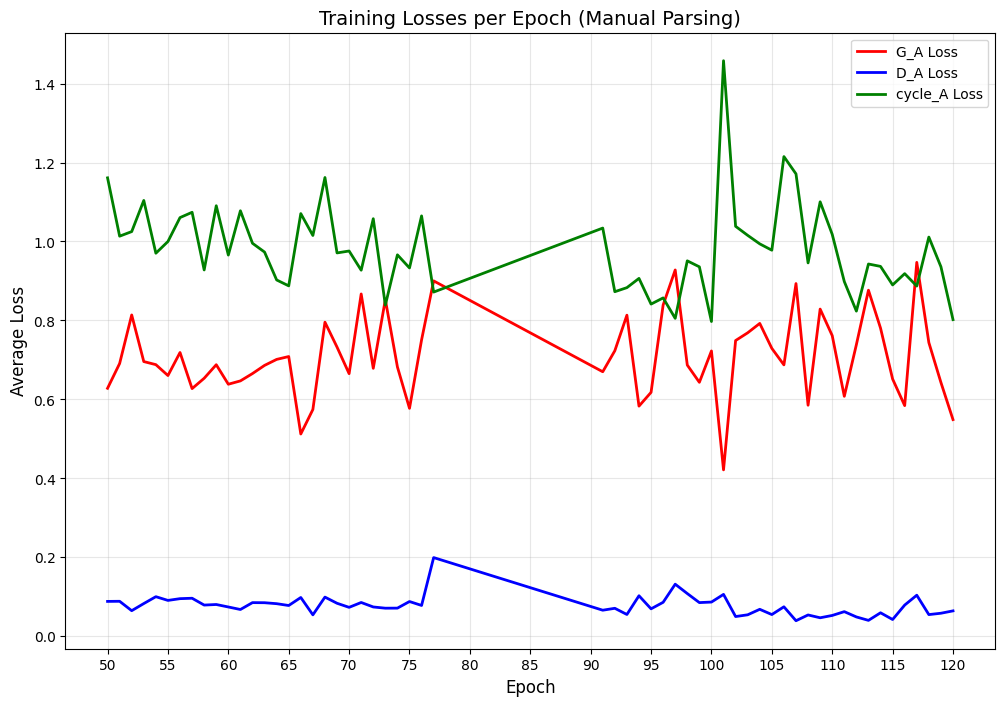

Manual loss plot saved to: /content/drive/MyDrive/finalProject_epoch_outputs/loss_plot_manual.png


In [ ]:
# Create a loss visualization with improved error handling
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Read the loss log with proper column names
loss_log_path = '/content/drive/MyDrive/finalProject_logs/loss_log.txt'

# Define column names based on your logging format
column_names = ['epoch', 'iteration', 'G_A', 'G_L1', 'cycle_A', 'idt_A', 'D_A', 'D_B', 'G_B', 'cycle_B', 'idt_B']

try:
    # Try to read with manually specified column names and no header
    df = pd.read_csv(loss_log_path, header=None, names=column_names,
                     on_bad_lines='skip')  # Skip problematic lines
    print(f"Successfully loaded {len(df)} rows of loss data")

    # Display the first few rows
    print("First few rows of data:")
    print(df.head())

    # Check what columns are actually present (some might be missing)
    print("Columns in dataframe:", df.columns.tolist())

    # Plot available losses
    plt.figure(figsize=(12, 8))

    # Group by epoch and calculate mean losses
    grouped = df.groupby('epoch')
    epochs = sorted(df['epoch'].unique())

    # Plot each loss column
    for column in df.columns[2:]:  # Skip epoch and iteration
        if column in df.columns:
            means = grouped[column].mean()
            plt.plot(epochs, means.values, label=column, linewidth=2)

    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.title('Training Losses per Epoch', fontsize=14)
    plt.grid(True, alpha=0.3)

    # Add epoch ticks
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))  # Tick every 5 epochs

    # Save the figure
    output_path = '/content/drive/MyDrive/finalProject_epoch_outputs/loss_plot.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Loss plot saved to: {output_path}")

    # Create generator vs discriminator plot
    plt.figure(figsize=(12, 6))

    # Generator losses (G_A, G_B)
    g_cols = [col for col in df.columns if col.startswith('G_')]
    if g_cols:
        g_data = grouped[g_cols].mean()
        g_avg = g_data.mean(axis=1)
        plt.plot(epochs, g_avg.values, 'r-', linewidth=2, label='Generator Loss (avg)')

    # Discriminator losses (D_A, D_B)
    d_cols = [col for col in df.columns if col.startswith('D_')]
    if d_cols:
        d_data = grouped[d_cols].mean()
        d_avg = d_data.mean(axis=1)
        plt.plot(epochs, d_avg.values, 'b-', linewidth=2, label='Discriminator Loss (avg)')

    # Cycle consistency losses
    cycle_cols = [col for col in df.columns if col.startswith('cycle_')]
    if cycle_cols:
        cycle_data = grouped[cycle_cols].mean()
        cycle_avg = cycle_data.mean(axis=1)
        plt.plot(epochs, cycle_avg.values, 'g-', linewidth=2, label='Cycle Loss (avg)')

    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Average Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.title('Loss Components by Category', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))  # Tick every 5 epochs

    # Save the figure
    summary_path = '/content/drive/MyDrive/finalProject_epoch_outputs/loss_summary.png'
    plt.savefig(summary_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Loss summary plot saved to: {summary_path}")

except Exception as e:
    print(f"Error processing loss log: {e}")

    # Alternative approach: Manual parsing
    print("Trying manual file parsing...")
    epochs = []
    g_a_losses = []
    d_a_losses = []
    cycle_a_losses = []

    try:
        with open(loss_log_path, 'r') as f:
            for line in f:
                try:
                    values = line.strip().split(',')
                    if len(values) >= 3:
                        epochs.append(int(float(values[0])))
                        g_a_losses.append(float(values[2]))

                        # Get D_A if available (should be at index 6)
                        if len(values) > 6:
                            d_a_losses.append(float(values[6]))

                        # Get cycle_A if available (should be at index 4)
                        if len(values) > 4:
                            cycle_a_losses.append(float(values[4]))
                except:
                    continue

        # Group by epoch and calculate means
        epoch_values = {}
        g_a_means = {}
        d_a_means = {}
        cycle_a_means = {}

        for i, epoch in enumerate(epochs):
            if epoch not in epoch_values:
                epoch_values[epoch] = []
                g_a_means[epoch] = []
                d_a_means[epoch] = []
                cycle_a_means[epoch] = []

            g_a_means[epoch].append(g_a_losses[i])

            if i < len(d_a_losses):
                d_a_means[epoch].append(d_a_losses[i])

            if i < len(cycle_a_losses):
                cycle_a_means[epoch].append(cycle_a_losses[i])

        # Calculate means
        unique_epochs = sorted(epoch_values.keys())
        g_a_avgs = [np.mean(g_a_means[e]) for e in unique_epochs]

        d_a_avgs = []
        for e in unique_epochs:
            if e in d_a_means and d_a_means[e]:
                d_a_avgs.append(np.mean(d_a_means[e]))
            else:
                d_a_avgs.append(np.nan)

        cycle_a_avgs = []
        for e in unique_epochs:
            if e in cycle_a_means and cycle_a_means[e]:
                cycle_a_avgs.append(np.mean(cycle_a_means[e]))
            else:
                cycle_a_avgs.append(np.nan)

        # Plot with manual parsing
        plt.figure(figsize=(12, 8))
        plt.plot(unique_epochs, g_a_avgs, 'r-', label='G_A Loss', linewidth=2)

        if len(d_a_avgs) == len(unique_epochs):
            plt.plot(unique_epochs, d_a_avgs, 'b-', label='D_A Loss', linewidth=2)

        if len(cycle_a_avgs) == len(unique_epochs):
            plt.plot(unique_epochs, cycle_a_avgs, 'g-', label='cycle_A Loss', linewidth=2)

        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Average Loss', fontsize=12)
        plt.legend(fontsize=10)
        plt.title('Training Losses per Epoch (Manual Parsing)', fontsize=14)
        plt.grid(True, alpha=0.3)

        # Add epoch ticks
        plt.xticks(np.arange(min(unique_epochs), max(unique_epochs)+1, 5))

        # Save the figure
        manual_path = '/content/drive/MyDrive/finalProject_epoch_outputs/loss_plot_manual.png'
        plt.savefig(manual_path, dpi=300, bbox_inches='tight')
        plt.show()

        print(f"Manual loss plot saved to: {manual_path}")

    except Exception as e2:
        print(f"Manual parsing also failed: {e2}")
        print("Please check the format of your loss log file.")

# Test on a single image

Loading trained model...
initialize network with normal
initialize network with normal
model [CycleGANModel] was created
loading the model from /content/drive/MyDrive/finalProject_checkpoints/anime_style_transfer/latest_net_G_A.pth
loading the model from /content/drive/MyDrive/finalProject_checkpoints/anime_style_transfer/latest_net_G_B.pth
---------- Networks initialized -------------
[Network G_A] Total number of parameters : 11.378 M
[Network G_B] Total number of parameters : 11.378 M
-----------------------------------------------
Model loaded successfully
Please upload an image of your face:


Saving noam.jpg to noam.jpg
Processing noam.jpg...


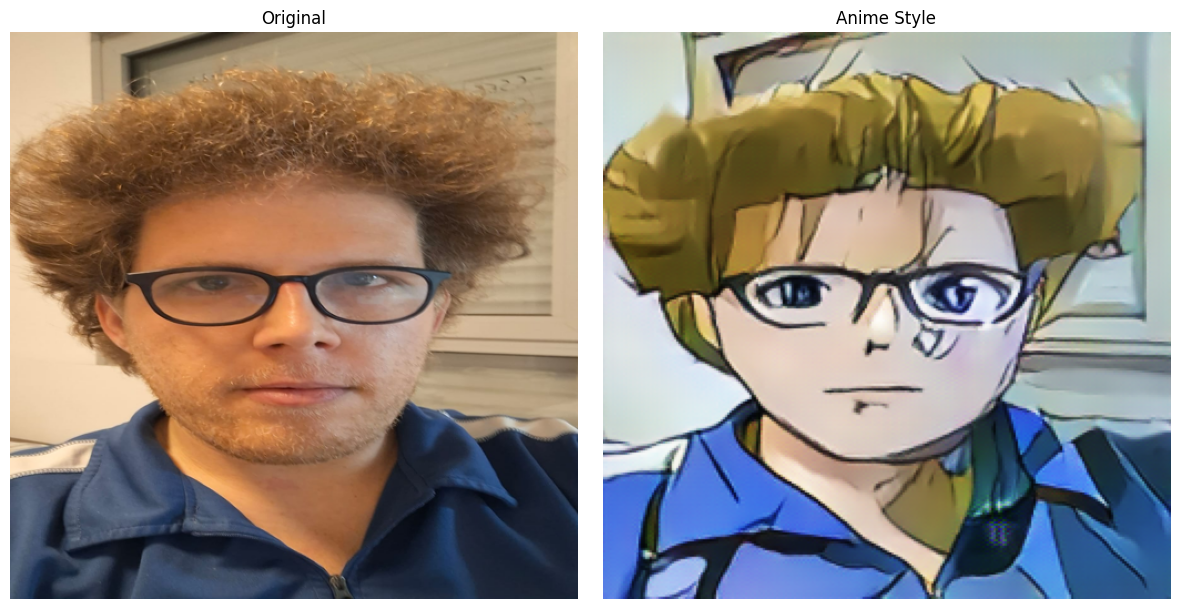

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved and downloaded: anime_noam.jpg


In [ ]:
# Test on a single image (e.g., your face)
import os
import torch
import numpy as np
from models import create_model
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from types import SimpleNamespace

# Define model parameters (with all required attributes)
opt = SimpleNamespace(
    checkpoints_dir='/content/drive/MyDrive/finalProject_checkpoints',
    name='anime_style_transfer',  # Your model name
    model='cycle_gan',
    input_nc=3,
    output_nc=3,
    ngf=64,
    ndf=64,
    netG='resnet_9blocks',
    netD='basic',
    norm='instance',
    no_dropout=True,
    init_type='normal',
    init_gain=0.02,
    gpu_ids=[0] if torch.cuda.is_available() else [],
    isTrain=False,
    preprocess='resize_and_crop',
    crop_size=256,
    load_size=286,
    direction='AtoB',
    epoch='latest',  # Or specify a specific epoch like '25'
    load_iter=0,    # Added missing attribute
    verbose=False,  # Added missing attribute
    suffix='',      # Added missing attribute
    dataset_mode='unaligned',  # Added missing attribute
    phase='test',   # Changed to test phase
    serial_batches=True,  # Added for deterministic results
    max_dataset_size=float('inf')  # Added missing attribute
)

# Load the model
print("Loading trained model...")
model = create_model(opt)
model.setup(opt)
model.eval()
print("Model loaded successfully")

# Function to convert tensor to image
def tensor2im(input_image, imtype=np.uint8):
    image_tensor = input_image.data
    image_numpy = image_tensor[0].cpu().float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    return image_numpy.astype(imtype)

# Function to process an image
def process_image(image_path):
    # Setup transform
    transform = transforms.Compose([
        transforms.Resize((opt.crop_size, opt.crop_size), transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load image
    img = Image.open(image_path).convert('RGB')

    # Keep original size for display
    img_display = img.copy()

    # Transform image
    input_tensor = transform(img).unsqueeze(0)
    if len(opt.gpu_ids) > 0 and torch.cuda.is_available():
        input_tensor = input_tensor.cuda(opt.gpu_ids[0])

    # Create test data dictionary
    test_data = {
        'A': input_tensor,
        'B': torch.zeros_like(input_tensor),
        'A_paths': [image_path],
        'B_paths': [image_path]
    }

    # Run model
    with torch.no_grad():
        model.set_input(test_data)
        model.test()
        visuals = model.get_current_visuals()
        fake_B = visuals['fake_B']

    # Convert output to image
    output_image = tensor2im(fake_B)

    # Resize original for display if very large
    if max(img_display.size) > 1000:
        img_display = img_display.resize((512, 512))

    # Display side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img_display)
    ax[0].set_title('Original')
    ax[0].axis('off')
    ax[1].imshow(output_image)
    ax[1].set_title('Anime Style')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

    return output_image

# Upload and test on an image
from google.colab import files
print("Please upload an image of your face:")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"Processing {filename}...")
    output = process_image(filename)

    # Save the output
    output_pil = Image.fromarray(output)
    output_path = f"anime_{filename}"
    output_pil.save(output_path)
    files.download(output_path)  # Download the result
    print(f"Saved and downloaded: {output_path}")

# ***Live inference***

split screen live

In [7]:
# Import all required libraries
import os
import torch
import numpy as np
from models import create_model
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from types import SimpleNamespace
from IPython.display import display, Javascript, HTML, clear_output
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import time

# Define model parameters with all required attributes
opt = SimpleNamespace(
    checkpoints_dir='/content/drive/MyDrive/finalProject_checkpoints',
    name='anime_style_transfer',  # Your model name
    model='cycle_gan',
    input_nc=3,
    output_nc=3,
    ngf=64,
    ndf=64,
    netG='resnet_9blocks',
    netD='basic',
    norm='instance',
    no_dropout=True,
    init_type='normal',
    init_gain=0.02,
    gpu_ids=[0] if torch.cuda.is_available() else [],
    isTrain=False,
    preprocess='resize_and_crop',
    crop_size=256,
    load_size=286,
    direction='AtoB',
    epoch='latest',  # Or specify a specific epoch like '41'
    load_iter=0,
    verbose=False,
    suffix='',
    dataset_mode='unaligned',
    phase='test',
    serial_batches=True,
    max_dataset_size=float('inf')
)

# Create output directory for screenshots
output_dir = '/content/drive/MyDrive/finalProject_epoch_outputs'
os.makedirs(output_dir, exist_ok=True)
screenshot_counter = 0

# Load the model
print("Loading trained model...")
model = create_model(opt)
model.setup(opt)
model.eval()
print("Model loaded successfully")

# Setup transform for the CycleGAN model
transform = transforms.Compose([
    transforms.Resize((opt.crop_size, opt.crop_size), transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Function to convert tensor to image
def tensor2im(input_image):
    image_tensor = input_image.data
    image_numpy = image_tensor[0].cpu().float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    return image_numpy.astype(np.uint8)

# Enhanced live webcam inference with JavaScript interface
def run_webcam_inference():
    # HTML and JS for webcam setup
    html_code = """
    <div id="webcam-container">
      <div style="position: relative; width: 720px; height: 540px; margin: 0 auto; display: flex; justify-content: center;">
        <div style="position: relative; width: 360px; height: 540px;">
          <video id="webcam" autoplay playsinline width="360" height="270" style="display: none"></video>
          <canvas id="input-canvas" width="360" height="270" style="border: 1px solid #ccc;"></canvas>
          <div style="margin-top: 5px; text-align: center;">Original Image</div>
        </div>
        <div style="position: relative; width: 360px; height: 540px;">
          <canvas id="output-canvas" width="360" height="270" style="border: 1px solid #ccc;"></canvas>
          <div style="margin-top: 5px; text-align: center;">Anime Style</div>
        </div>
      </div>
      <div style="text-align: center; margin-top: 20px;">
        <button id="start-button" style="padding: 8px 16px; font-size: 16px; margin-right: 10px;">Start Webcam</button>
        <button id="screenshot-button" style="padding: 8px 16px; font-size: 16px;">Take Screenshot</button>
      </div>
    </div>

    <script>
      var inputCanvas = document.getElementById('input-canvas');
      var outputCanvas = document.getElementById('output-canvas');
      var webcamElement = document.getElementById('webcam');
      var startButton = document.getElementById('start-button');
      var screenshotButton = document.getElementById('screenshot-button');

      var inputCtx = inputCanvas.getContext('2d');
      var outputCtx = outputCanvas.getContext('2d');
      var mediaStream = null;
      var isRunning = false;
      var processedImage = null;

      // Start button click handler
      startButton.addEventListener('click', function() {
        if (!isRunning) {
          startWebcam();
          this.textContent = 'Stop Webcam';
        } else {
          stopWebcam();
          this.textContent = 'Start Webcam';
        }
      });

      // Screenshot button click handler
      screenshotButton.addEventListener('click', function() {
        if (isRunning && processedImage) {
          takeScreenshot();
        } else {
          alert('Webcam must be running to take a screenshot');
        }
      });

      async function startWebcam() {
        try {
          const constraints = {
            video: {
              width: 360,
              height: 270
            }
          };

          mediaStream = await navigator.mediaDevices.getUserMedia(constraints);
          webcamElement.srcObject = mediaStream;
          isRunning = true;

          requestAnimationFrame(updateCanvas);
        } catch (e) {
          console.error('Error starting webcam:', e);
          // Show error on canvas
          inputCtx.fillStyle = '#000000';
          inputCtx.fillRect(0, 0, inputCanvas.width, inputCanvas.height);
          inputCtx.fillStyle = '#FF0000';
          inputCtx.font = '16px Arial';
          inputCtx.fillText('Error accessing webcam', 100, 135);
        }
      }

      function stopWebcam() {
        if (mediaStream) {
          mediaStream.getTracks().forEach(track => track.stop());
          isRunning = false;
          startButton.textContent = 'Start Webcam';

          // Clear the canvases
          inputCtx.fillStyle = '#000000';
          inputCtx.fillRect(0, 0, inputCanvas.width, inputCanvas.height);
          inputCtx.fillStyle = '#FFFFFF';
          inputCtx.font = '16px Arial';
          inputCtx.fillText('Webcam stopped', 120, 135);

          outputCtx.fillStyle = '#000000';
          outputCtx.fillRect(0, 0, outputCanvas.width, outputCanvas.height);
          processedImage = null;
        }
      }

      function updateCanvas() {
        if (isRunning) {
          // Draw video frame on input canvas
          inputCtx.drawImage(webcamElement, 0, 0, inputCanvas.width, inputCanvas.height);

          // Draw processed image on output canvas if available
          if (processedImage) {
            const img = new Image();
            img.onload = function() {
              outputCtx.drawImage(img, 0, 0, outputCanvas.width, outputCanvas.height);
            };
            img.src = processedImage;
          }

          requestAnimationFrame(updateCanvas);
        }
      }

      // Function to get current frame data for Python
      function getFrameData() {
        if (!isRunning) return null;
        return inputCanvas.toDataURL('image/jpeg');
      }

      // Function to update processed image
      function updateProcessedImage(imgData) {
        processedImage = imgData;
      }

      // Function to check if webcam is running
      function isWebcamRunning() {
        return isRunning;
      }

      // Function to signal a screenshot request
      function takeScreenshot() {
        window.takeScreenshot = true;

        // Visual feedback that screenshot was taken
        const flash = document.createElement('div');
        flash.style.position = 'fixed';
        flash.style.top = '0';
        flash.style.left = '0';
        flash.style.width = '100%';
        flash.style.height = '100%';
        flash.style.backgroundColor = 'white';
        flash.style.opacity = '0.3';
        flash.style.zIndex = '9999';
        flash.style.pointerEvents = 'none';
        document.body.appendChild(flash);

        setTimeout(() => {
          document.body.removeChild(flash);
        }, 150);
      }

      // Expose functions to Python
      window.getFrameData = getFrameData;
      window.updateProcessedImage = updateProcessedImage;
      window.isWebcamRunning = isWebcamRunning;
      window.takeScreenshot = false;
      window.checkScreenshot = function() {
        if (window.takeScreenshot) {
          window.takeScreenshot = false;
          return true;
        }
        return false;
      };

      // Initial canvas states
      inputCtx.fillStyle = '#000000';
      inputCtx.fillRect(0, 0, inputCanvas.width, inputCanvas.height);
      inputCtx.fillStyle = '#FFFFFF';
      inputCtx.font = '16px Arial';
      inputCtx.fillText('Click "Start Webcam" to begin', 70, 135);

      outputCtx.fillStyle = '#000000';
      outputCtx.fillRect(0, 0, outputCanvas.width, outputCanvas.height);
      outputCtx.fillStyle = '#FFFFFF';
      outputCtx.font = '16px Arial';
      outputCtx.fillText('Anime style will appear here', 70, 135);
    </script>
    """

    # Display the HTML interface
    display(HTML(html_code))

    # Wait briefly for HTML to load
    time.sleep(1)

    print("Click 'Start Webcam' to begin. Click 'Take Screenshot' to save the current image.")

    # Create device variable
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Main inference loop
    try:
        global screenshot_counter
        while True:
            # Check if webcam is still running
            is_running = eval_js('isWebcamRunning()')
            if not is_running:
                time.sleep(0.5)  # Check periodically if user starts webcam again
                continue

            # Get the current frame
            frame_data = eval_js('getFrameData()')

            # Skip if no frame
            if not frame_data:
                time.sleep(0.1)
                continue

            # Process the frame
            encoded_data = frame_data.split(',')[1]
            nparr = np.frombuffer(b64decode(encoded_data), np.uint8)
            img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

            # Convert BGR to RGB for processing
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Convert to PIL Image for transformation
            pil_image = Image.fromarray(img_rgb)

            # Transform for CycleGAN
            input_tensor = transform(pil_image).unsqueeze(0)
            if torch.cuda.is_available():
                input_tensor = input_tensor.cuda()

            # Create test data dictionary for CycleGAN
            test_data = {
                'A': input_tensor,
                'B': torch.zeros_like(input_tensor),
                'A_paths': ['webcam'],
                'B_paths': ['webcam']
            }

            # Run CycleGAN inference
            with torch.no_grad():
                model.set_input(test_data)
                model.test()
                visuals = model.get_current_visuals()
                fake_B = visuals['fake_B']

            # Convert output to image
            output_image = tensor2im(fake_B)

            # Convert to base64 for display
            pil_output = Image.fromarray(output_image)
            buffer = np.array(pil_output)
            _, buffer = cv2.imencode('.jpg', cv2.cvtColor(buffer, cv2.COLOR_RGB2BGR))
            img_str = 'data:image/jpeg;base64,' + b64encode(buffer).decode('utf-8')

            # Update the processed image in the UI
            eval_js(f'updateProcessedImage("{img_str}")')

            # Check if screenshot requested
            screenshot_requested = eval_js('checkScreenshot()')
            if screenshot_requested:
                # Create side-by-side image for saving
                combined = np.hstack((img_rgb, output_image))
                screenshot_path = os.path.join(output_dir, f'webcam_screenshot_{screenshot_counter}.png')
                Image.fromarray(combined).save(screenshot_path)
                print(f"Saved screenshot to {screenshot_path}")
                screenshot_counter += 1

            # Sleep briefly to reduce CPU usage
            time.sleep(0.1)

    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
    finally:
        print("Inference loop ended")

# Run the function
run_webcam_inference()

Loading trained model...
initialize network with normal
initialize network with normal
model [CycleGANModel] was created
loading the model from /content/drive/MyDrive/finalProject_checkpoints/anime_style_transfer/latest_net_G_A.pth
loading the model from /content/drive/MyDrive/finalProject_checkpoints/anime_style_transfer/latest_net_G_B.pth
---------- Networks initialized -------------
[Network G_A] Total number of parameters : 11.378 M
[Network G_B] Total number of parameters : 11.378 M
-----------------------------------------------
Model loaded successfully


Click 'Start Webcam' to begin. Click 'Take Screenshot' to save the current image.
Using device: cuda
Inference loop ended


KeyboardInterrupt: 

Live- full screen


In [ ]:
# Import all required libraries
import os
import torch
import numpy as np
from models import create_model
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from types import SimpleNamespace
from IPython.display import display, Javascript, HTML, clear_output
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import time

# Define model parameters with all required attributes
opt = SimpleNamespace(
    checkpoints_dir='/content/drive/MyDrive/finalProject_checkpoints',
    name='anime_style_transfer',  # Your model name
    model='cycle_gan',
    input_nc=3,
    output_nc=3,
    ngf=64,
    ndf=64,
    netG='resnet_9blocks',
    netD='basic',
    norm='instance',
    no_dropout=True,
    init_type='normal',
    init_gain=0.02,
    gpu_ids=[0] if torch.cuda.is_available() else [],
    isTrain=False,
    preprocess='resize_and_crop',
    crop_size=256,
    load_size=286,
    direction='AtoB',
    epoch='latest',  # Or specify a specific epoch like '41'
    load_iter=0,
    verbose=False,
    suffix='',
    dataset_mode='unaligned',
    phase='test',
    serial_batches=True,
    max_dataset_size=float('inf')
)

# Create output directory for screenshots
output_dir = '/content/drive/MyDrive/finalProject_epoch_outputs'
os.makedirs(output_dir, exist_ok=True)
screenshot_counter = 0

# Load the model
print("Loading trained model...")
model = create_model(opt)
model.setup(opt)
model.eval()
print("Model loaded successfully")

# Setup transform for the CycleGAN model
transform = transforms.Compose([
    transforms.Resize((opt.crop_size, opt.crop_size), transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Function to convert tensor to image
def tensor2im(input_image):
    image_tensor = input_image.data
    image_numpy = image_tensor[0].cpu().float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    return image_numpy.astype(np.uint8)

# Enhanced live webcam inference with JavaScript interface - single screen version
def run_webcam_inference():
    # HTML and JS for webcam setup - modified for single screen
    html_code = """
    <div id="webcam-container">
      <div style="position: relative; width: 540px; height: 400px; margin: 0 auto; display: flex; justify-content: center;">
        <div style="position: relative; width: 540px; height: 400px;">
          <video id="webcam" autoplay playsinline width="540" height="360" style="display: none"></video>
          <canvas id="output-canvas" width="540" height="360" style="border: 1px solid #ccc;"></canvas>
          <div style="margin-top: 5px; text-align: center;">Anime Style Transformation</div>
        </div>
      </div>
      <div style="text-align: center; margin-top: 20px;">
        <button id="start-button" style="padding: 8px 16px; font-size: 16px; margin-right: 10px;">Start Webcam</button>
        <button id="screenshot-button" style="padding: 8px 16px; font-size: 16px;">Take Screenshot</button>
        <div id="switch-container" style="margin-top: 10px;">
          <label for="toggle-view" style="margin-right: 10px;">Show original: </label>
          <input type="checkbox" id="toggle-view" style="vertical-align: middle;">
        </div>
      </div>
    </div>

    <script>
      var outputCanvas = document.getElementById('output-canvas');
      var webcamElement = document.getElementById('webcam');
      var startButton = document.getElementById('start-button');
      var screenshotButton = document.getElementById('screenshot-button');
      var toggleView = document.getElementById('toggle-view');

      var outputCtx = outputCanvas.getContext('2d');
      var mediaStream = null;
      var isRunning = false;
      var processedImage = null;
      var originalImage = null;
      var showOriginal = false;

      // Start button click handler
      startButton.addEventListener('click', function() {
        if (!isRunning) {
          startWebcam();
          this.textContent = 'Stop Webcam';
        } else {
          stopWebcam();
          this.textContent = 'Start Webcam';
        }
      });

      // Screenshot button click handler
      screenshotButton.addEventListener('click', function() {
        if (isRunning && (processedImage || originalImage)) {
          takeScreenshot();
        } else {
          alert('Webcam must be running to take a screenshot');
        }
      });

      // Toggle view handler
      toggleView.addEventListener('change', function() {
        showOriginal = this.checked;
        updateDisplayedImage();
      });

      // Update the display based on toggle state
      function updateDisplayedImage() {
        if (showOriginal && originalImage) {
          displayImage(originalImage);
        } else if (processedImage) {
          displayImage(processedImage);
        }
      }

      // Display an image on the canvas
      function displayImage(imgData) {
        const img = new Image();
        img.onload = function() {
          outputCtx.drawImage(img, 0, 0, outputCanvas.width, outputCanvas.height);
        };
        img.src = imgData;
      }

      async function startWebcam() {
        try {
          const constraints = {
            video: {
              width: 540,
              height: 360
            }
          };

          mediaStream = await navigator.mediaDevices.getUserMedia(constraints);
          webcamElement.srcObject = mediaStream;
          isRunning = true;

          requestAnimationFrame(updateCanvas);
        } catch (e) {
          console.error('Error starting webcam:', e);
          // Show error on canvas
          outputCtx.fillStyle = '#000000';
          outputCtx.fillRect(0, 0, outputCanvas.width, outputCanvas.height);
          outputCtx.fillStyle = '#FF0000';
          outputCtx.font = '16px Arial';
          outputCtx.fillText('Error accessing webcam', 180, 180);
        }
      }

      function stopWebcam() {
        if (mediaStream) {
          mediaStream.getTracks().forEach(track => track.stop());
          isRunning = false;
          startButton.textContent = 'Start Webcam';

          // Clear the canvas
          outputCtx.fillStyle = '#000000';
          outputCtx.fillRect(0, 0, outputCanvas.width, outputCanvas.height);
          outputCtx.fillStyle = '#FFFFFF';
          outputCtx.font = '16px Arial';
          outputCtx.fillText('Webcam stopped', 200, 180);

          processedImage = null;
          originalImage = null;
        }
      }

      function updateCanvas() {
        if (isRunning) {
          // Update the displayed image based on toggle state
          updateDisplayedImage();
          requestAnimationFrame(updateCanvas);
        }
      }

      // Function to get current frame data for Python
      function getFrameData() {
        if (!isRunning) return null;

        // Create a hidden canvas to capture the frame
        const hiddenCanvas = document.createElement('canvas');
        hiddenCanvas.width = 360;
        hiddenCanvas.height = 270;
        const ctx = hiddenCanvas.getContext('2d');
        ctx.drawImage(webcamElement, 0, 0, hiddenCanvas.width, hiddenCanvas.height);

        return hiddenCanvas.toDataURL('image/jpeg');
      }

      // Function to update processed image
      function updateProcessedImage(imgData) {
        processedImage = imgData;
        if (!showOriginal) {
          displayImage(processedImage);
        }
      }

      // Function to update original image
      function updateOriginalImage(imgData) {
        originalImage = imgData;
        if (showOriginal) {
          displayImage(originalImage);
        }
      }

      // Function to check if webcam is running
      function isWebcamRunning() {
        return isRunning;
      }

      // Function to signal a screenshot request
      function takeScreenshot() {
        window.takeScreenshot = true;

        // Visual feedback that screenshot was taken
        const flash = document.createElement('div');
        flash.style.position = 'fixed';
        flash.style.top = '0';
        flash.style.left = '0';
        flash.style.width = '100%';
        flash.style.height = '100%';
        flash.style.backgroundColor = 'white';
        flash.style.opacity = '0.3';
        flash.style.zIndex = '9999';
        flash.style.pointerEvents = 'none';
        document.body.appendChild(flash);

        setTimeout(() => {
          document.body.removeChild(flash);
        }, 150);
      }

      // Expose functions to Python
      window.getFrameData = getFrameData;
      window.updateProcessedImage = updateProcessedImage;
      window.updateOriginalImage = updateOriginalImage;
      window.isWebcamRunning = isWebcamRunning;
      window.isShowingOriginal = function() { return showOriginal; };
      window.takeScreenshot = false;
      window.checkScreenshot = function() {
        if (window.takeScreenshot) {
          window.takeScreenshot = false;
          return true;
        }
        return false;
      };

      // Initial canvas state
      outputCtx.fillStyle = '#000000';
      outputCtx.fillRect(0, 0, outputCanvas.width, outputCanvas.height);
      outputCtx.fillStyle = '#FFFFFF';
      outputCtx.font = '16px Arial';
      outputCtx.fillText('Click "Start Webcam" to begin', 160, 180);
    </script>
    """

    # Display the HTML interface
    display(HTML(html_code))

    # Wait briefly for HTML to load
    time.sleep(1)

    print("Click 'Start Webcam' to begin. Click 'Take Screenshot' to save the current image.")
    print("Use the 'Show original' checkbox to toggle between original and anime style view.")

    # Create device variable
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Main inference loop
    try:
        global screenshot_counter
        while True:
            # Check if webcam is still running
            is_running = eval_js('isWebcamRunning()')
            if not is_running:
                time.sleep(0.5)  # Check periodically if user starts webcam again
                continue

            # Get the current frame
            frame_data = eval_js('getFrameData()')

            # Skip if no frame
            if not frame_data:
                time.sleep(0.1)
                continue

            # Process the frame
            encoded_data = frame_data.split(',')[1]
            nparr = np.frombuffer(b64decode(encoded_data), np.uint8)
            img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

            # Convert BGR to RGB for processing
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Update original image in the UI
            _, buffer_orig = cv2.imencode('.jpg', cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
            img_str_orig = 'data:image/jpeg;base64,' + b64encode(buffer_orig).decode('utf-8')
            eval_js(f'updateOriginalImage("{img_str_orig}")')

            # Convert to PIL Image for transformation
            pil_image = Image.fromarray(img_rgb)

            # Transform for CycleGAN
            input_tensor = transform(pil_image).unsqueeze(0)
            if torch.cuda.is_available():
                input_tensor = input_tensor.cuda()

            # Create test data dictionary for CycleGAN
            test_data = {
                'A': input_tensor,
                'B': torch.zeros_like(input_tensor),
                'A_paths': ['webcam'],
                'B_paths': ['webcam']
            }

            # Run CycleGAN inference
            with torch.no_grad():
                model.set_input(test_data)
                model.test()
                visuals = model.get_current_visuals()
                fake_B = visuals['fake_B']

            # Convert output to image
            output_image = tensor2im(fake_B)

            # Convert to base64 for display
            pil_output = Image.fromarray(output_image)
            buffer = np.array(pil_output)
            _, buffer = cv2.imencode('.jpg', cv2.cvtColor(buffer, cv2.COLOR_RGB2BGR))
            img_str = 'data:image/jpeg;base64,' + b64encode(buffer).decode('utf-8')

            # Update the processed image in the UI
            eval_js(f'updateProcessedImage("{img_str}")')

            # Check if screenshot requested
            screenshot_requested = eval_js('checkScreenshot()')
            if screenshot_requested:
                # Get current view state
                showing_original = eval_js('isShowingOriginal()')

                # Save the current view (either original or processed)
                if showing_original:
                    screenshot_path = os.path.join(output_dir, f'webcam_original_{screenshot_counter}.png')
                    Image.fromarray(img_rgb).save(screenshot_path)
                else:
                    screenshot_path = os.path.join(output_dir, f'webcam_anime_{screenshot_counter}.png')
                    Image.fromarray(output_image).save(screenshot_path)

                print(f"Saved screenshot to {screenshot_path}")
                screenshot_counter += 1

            # Sleep briefly to reduce CPU usage
            time.sleep(0.1)

    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
    finally:
        print("Inference loop ended")

# Run the function
run_webcam_inference()

Loading trained model...
initialize network with normal
initialize network with normal
model [CycleGANModel] was created
loading the model from /content/drive/MyDrive/finalProject_checkpoints/anime_style_transfer/latest_net_G_A.pth
loading the model from /content/drive/MyDrive/finalProject_checkpoints/anime_style_transfer/latest_net_G_B.pth
---------- Networks initialized -------------
[Network G_A] Total number of parameters : 11.378 M
[Network G_B] Total number of parameters : 11.378 M
-----------------------------------------------
Model loaded successfully


Click 'Start Webcam' to begin. Click 'Take Screenshot' to save the current image.
Use the 'Show original' checkbox to toggle between original and anime style view.
Using device: cuda
Inference loop ended


KeyboardInterrupt: 

# Functions for word ducument:

3.Describe your data-set (size, resolution, show 10 screenshots of train and 10 of test images):

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

# Dataset paths
dataset_root = '/content/datasets/animeDS/dataset'
trainA_path = os.path.join(dataset_root, 'trainA')  # Real faces
trainB_path = os.path.join(dataset_root, 'trainB')  # Anime faces
testA_path = os.path.join(dataset_root, 'testA')    # Real faces test
testB_path = os.path.join(dataset_root, 'testB')    # Anime faces test

def analyze_dataset(path, domain_name):
    """Analyze dataset folder and return info"""
    if not os.path.exists(path):
        print(f"⚠️ Path not found: {path}")
        return [], None, None

    # Get all image files
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    image_files = []
    for file in os.listdir(path):
        if any(file.lower().endswith(ext) for ext in valid_extensions):
            image_files.append(file)

    if not image_files:
        print(f"⚠️ No images found in {path}")
        return [], None, None

    # Sample first image to get format info
    sample_img_path = os.path.join(path, image_files[0])
    sample_img = Image.open(sample_img_path)

    print(f"\n📁 {domain_name} Dataset Analysis:")
    print(f"   📊 Total Images: {len(image_files)}")
    print(f"   📐 Resolution: {sample_img.size[0]}×{sample_img.size[1]} pixels")
    print(f"   🎨 Color Mode: {sample_img.mode}")
    print(f"   📁 Path: {path}")

    return image_files, sample_img.size, sample_img.mode

def show_dataset_samples(path, image_files, title, num_samples=10):
    """Display random samples from dataset"""
    if not image_files or len(image_files) == 0:
        print(f"No images to display for {title}")
        return

    # Select random samples
    num_samples = min(num_samples, len(image_files))
    selected_files = random.sample(image_files, num_samples)

    # Create subplot grid
    cols = 5
    rows = (num_samples + cols - 1) // cols

    plt.figure(figsize=(15, 3 * rows))
    plt.suptitle(f'{title} - Sample Images', fontsize=16, fontweight='bold')

    for i, filename in enumerate(selected_files):
        img_path = os.path.join(path, filename)
        try:
            img = Image.open(img_path)

            plt.subplot(rows, cols, i + 1)
            plt.imshow(np.array(img))
            plt.title(f'{filename[:15]}...', fontsize=8)
            plt.axis('off')
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    plt.tight_layout()
    plt.show()

# Analyze all dataset folders
print("="*60)
print("🔍 DATASET ANALYSIS")
print("="*60)

trainA_files, trainA_size, trainA_mode = analyze_dataset(trainA_path, "Training Real Faces (Domain A)")
trainB_files, trainB_size, trainB_mode = analyze_dataset(trainB_path, "Training Anime Faces (Domain B)")
testA_files, testA_size, testA_mode = analyze_dataset(testA_path, "Test Real Faces (Domain A)")
testB_files, testB_size, testB_mode = analyze_dataset(testB_path, "Test Anime Faces (Domain B)")

# Summary
print(f"\n{'='*60}")
print("📋 DATASET SUMMARY")
print(f"{'='*60}")
print(f"Training Images: {len(trainA_files)} real faces + {len(trainB_files)} anime faces = {len(trainA_files) + len(trainB_files)} total")
print(f"Test Images: {len(testA_files)} real faces + {len(testB_files)} anime faces = {len(testA_files) + len(testB_files)} total")
print(f"Image Resolution: {trainA_size if trainA_size else 'N/A'}")
print(f"Color Format: {trainA_mode if trainA_mode else 'N/A'}")

# Show sample images from each dataset
print(f"\n{'='*60}")
print("🖼️ DATASET SAMPLES")
print(f"{'='*60}")

if trainA_files:
    show_dataset_samples(trainA_path, trainA_files, "Training Real Faces (Domain A)", 10)

if trainB_files:
    show_dataset_samples(trainB_path, trainB_files, "Training Anime Faces (Domain B)", 10)

if testA_files:
    show_dataset_samples(testA_path, testA_files, "Test Real Faces (Domain A)", 10)

if testB_files:
    show_dataset_samples(testB_path, testB_files, "Test Anime Faces (Domain B)", 10)

# Additional dataset statistics
def get_resolution_stats(path, image_files, sample_size=50):
    """Check if all images have consistent resolution"""
    if not image_files:
        return

    sample_files = random.sample(image_files, min(sample_size, len(image_files)))
    resolutions = []

    for filename in sample_files:
        try:
            img_path = os.path.join(path, filename)
            img = Image.open(img_path)
            resolutions.append(img.size)
        except:
            continue

    unique_resolutions = list(set(resolutions))
    print(f"   📐 Resolution consistency check ({len(sample_files)} samples):")
    if len(unique_resolutions) == 1:
        print(f"      ✅ All images are {unique_resolutions[0][0]}×{unique_resolutions[0][1]}")
    else:
        print(f"      ⚠️ Found {len(unique_resolutions)} different resolutions:")
        for res in unique_resolutions[:5]:  # Show first 5
            count = resolutions.count(res)
            print(f"         {res[0]}×{res[1]}: {count} images")

print(f"\n{'='*60}")
print("🔍 RESOLUTION CONSISTENCY CHECK")
print(f"{'='*60}")

if trainA_files:
    print("Training Real Faces (Domain A):")
    get_resolution_stats(trainA_path, trainA_files)

if trainB_files:
    print("Training Anime Faces (Domain B):")
    get_resolution_stats(trainB_path, trainB_files)

Output hidden; open in https://colab.research.google.com to view.

5. Screenshots of the summary of all DNNs involved:


In [ ]:
from models import create_model
from types import SimpleNamespace
import torch

# Create simplified model just to print architecture
opt = SimpleNamespace(
    model='cycle_gan',
    netG='resnet_9blocks',
    netD='basic',
    input_nc=3,
    output_nc=3,
    ngf=64,
    ndf=64,
    norm='instance',
    no_dropout=True,
    init_type='normal',
    init_gain=0.02,
    gpu_ids=[],
    isTrain=True,
    # Add missing required parameters
    checkpoints_dir='./checkpoints',
    name='temp_model',
    dataset_mode='unaligned',
    phase='train',
    preprocess='resize_and_crop',
    load_size=286,
    crop_size=256,
    max_dataset_size=float('inf'),
    serial_batches=False,
    num_threads=4,
    batch_size=1,
    lambda_A=10.0,
    lambda_B=10.0,
    lambda_identity=0.5,
    epoch='latest',
    epoch_count=1,  # ADD THIS - Missing parameter
    load_iter=0,
    verbose=False,
    suffix='',
    direction='AtoB',
    continue_train=False,
    niter=100,
    niter_decay=100,
    beta1=0.5,
    lr=0.0002,
    gan_mode='lsgan',
    pool_size=50,
    lr_policy='linear',
    lr_decay_iters=50,
    no_lsgan=False,
    display_freq=400,
    display_ncols=4,
    display_winsize=256,
    display_id=1,
    display_env='main',
    display_port=8097,
    update_html_freq=1000,
    print_freq=100,
    save_latest_freq=5000,
    save_epoch_freq=5,
    save_by_iter=False,
    no_flip=False,
    n_layers_D=3
)

try:
    # Create model (but don't setup to avoid loading checkpoint issues)
    model = create_model(opt)

    # Initialize the networks without loading checkpoints
    model.initialize(opt)

    print("="*60)
    print("GENERATOR A->B ARCHITECTURE (Face to Anime):")
    print("="*60)
    print(model.netG_A)
    print(f"\nNumber of Generator A->B parameters: {sum(p.numel() for p in model.netG_A.parameters()):,}")

    print("\n" + "="*60)
    print("GENERATOR B->A ARCHITECTURE (Anime to Face):")
    print("="*60)
    print(model.netG_B)
    print(f"\nNumber of Generator B->A parameters: {sum(p.numel() for p in model.netG_B.parameters()):,}")

    print("\n" + "="*60)
    print("DISCRIMINATOR A ARCHITECTURE (Face Discriminator):")
    print("="*60)
    print(model.netD_A)
    print(f"\nNumber of Discriminator A parameters: {sum(p.numel() for p in model.netD_A.parameters()):,}")

    print("\n" + "="*60)
    print("DISCRIMINATOR B ARCHITECTURE (Anime Discriminator):")
    print("="*60)
    print(model.netD_B)
    print(f"\nNumber of Discriminator B parameters: {sum(p.numel() for p in model.netD_B.parameters()):,}")

    print("\n" + "="*60)
    print("CYCLEGAN NETWORK SUMMARY:")
    print("="*60)
    total_params = (sum(p.numel() for p in model.netG_A.parameters()) +
                   sum(p.numel() for p in model.netG_B.parameters()) +
                   sum(p.numel() for p in model.netD_A.parameters()) +
                   sum(p.numel() for p in model.netD_B.parameters()))

    print(f"Generator A->B (Face to Anime): {sum(p.numel() for p in model.netG_A.parameters()):,} parameters")
    print(f"Generator B->A (Anime to Face): {sum(p.numel() for p in model.netG_B.parameters()):,} parameters")
    print(f"Discriminator A (Face Judge): {sum(p.numel() for p in model.netD_A.parameters()):,} parameters")
    print(f"Discriminator B (Anime Judge): {sum(p.numel() for p in model.netD_B.parameters()):,} parameters")
    print(f"TOTAL PARAMETERS: {total_params:,}")

    # Also print detailed network specifications
    print("\n" + "="*60)
    print("NETWORK SPECIFICATIONS:")
    print("="*60)
    print(f"Input Image Size: {opt.crop_size}x{opt.crop_size}")
    print(f"Input Channels: {opt.input_nc} (RGB)")
    print(f"Output Channels: {opt.output_nc} (RGB)")
    print(f"Generator Architecture: {opt.netG} (ResNet with 9 residual blocks)")
    print(f"Generator Base Features: {opt.ngf}")
    print(f"Discriminator Architecture: {opt.netD} (PatchGAN)")
    print(f"Discriminator Base Features: {opt.ndf}")
    print(f"Discriminator Layers: {opt.n_layers_D}")
    print(f"Normalization: {opt.norm}")
    print(f"No Dropout: {opt.no_dropout}")

    print("\n" + "="*60)
    print("LOSS FUNCTION COMPONENTS:")
    print("="*60)
    print(f"Adversarial Loss: {opt.gan_mode} (Least Squares GAN)")
    print(f"Cycle Consistency Weight (λA): {opt.lambda_A}")
    print(f"Cycle Consistency Weight (λB): {opt.lambda_B}")
    print(f"Identity Loss Weight: {opt.lambda_identity}")

except Exception as e:
    print(f"Error creating model: {e}")

    # Alternative approach - create networks directly
    try:
        print("Trying alternative approach...")
        from models.networks import define_G, define_D

        # Create generator
        netG = define_G(opt.input_nc, opt.output_nc, opt.ngf, opt.netG, opt.norm,
                       not opt.no_dropout, opt.init_type, opt.init_gain, opt.gpu_ids)

        # Create discriminator
        netD = define_D(opt.input_nc, opt.ndf, opt.netD, opt.n_layers_D, opt.norm,
                       opt.init_type, opt.init_gain, opt.gpu_ids)

        print("="*60)
        print("GENERATOR ARCHITECTURE:")
        print("="*60)
        print(netG)
        print(f"\nGenerator parameters: {sum(p.numel() for p in netG.parameters()):,}")

        print("\n" + "="*60)
        print("DISCRIMINATOR ARCHITECTURE:")
        print("="*60)
        print(netD)
        print(f"\nDiscriminator parameters: {sum(p.numel() for p in netD.parameters()):,}")

        print(f"\nNote: CycleGAN uses 2 generators and 2 discriminators")
        print(f"Total CycleGAN parameters: ~{(sum(p.numel() for p in netG.parameters()) + sum(p.numel() for p in netD.parameters())) * 2:,}")

    except Exception as e2:
        print(f"Alternative approach also failed: {e2}")
        print("Make sure you're running this in the pytorch-CycleGAN-and-pix2pix directory")

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
model [CycleGANModel] was created
Error creating model: 'CycleGANModel' object has no attribute 'initialize'
Trying alternative approach...
initialize network with normal
initialize network with normal
GENERATOR ARCHITECTURE:
ResnetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplac

6. Screenshots of the training process per epoch (all loss values):


Parsing log file...
Total lines in log file: 938
First 5 lines of log file:
Line 1: 50,100,0.6217,0.0000,1.2036,0.4879,0.2181,0.1822
Line 2: 50,200,0.7887,0.0000,0.9544,0.4639,0.0450,0.0673
Line 3: 50,300,1.0174,0.0000,1.0538,0.3602,0.1418,0.1433
Line 4: 50,400,0.8090,0.0000,1.0860,0.4732,0.0438,0.0823
Line 5: 50,500,0.6021,0.0000,0.8235,0.2744,0.0763,0.2319
Successfully parsed 58 epochs
Epoch range: 50 to 120
G_A: 58/58 epochs have data
G_B: 57/58 epochs have data
D_A: 58/58 epochs have data
D_B: 58/58 epochs have data
cycle_A: 58/58 epochs have data
cycle_B: 57/58 epochs have data
idt_A: 58/58 epochs have data
idt_B: 57/58 epochs have data
Creating plots for 8 loss types...


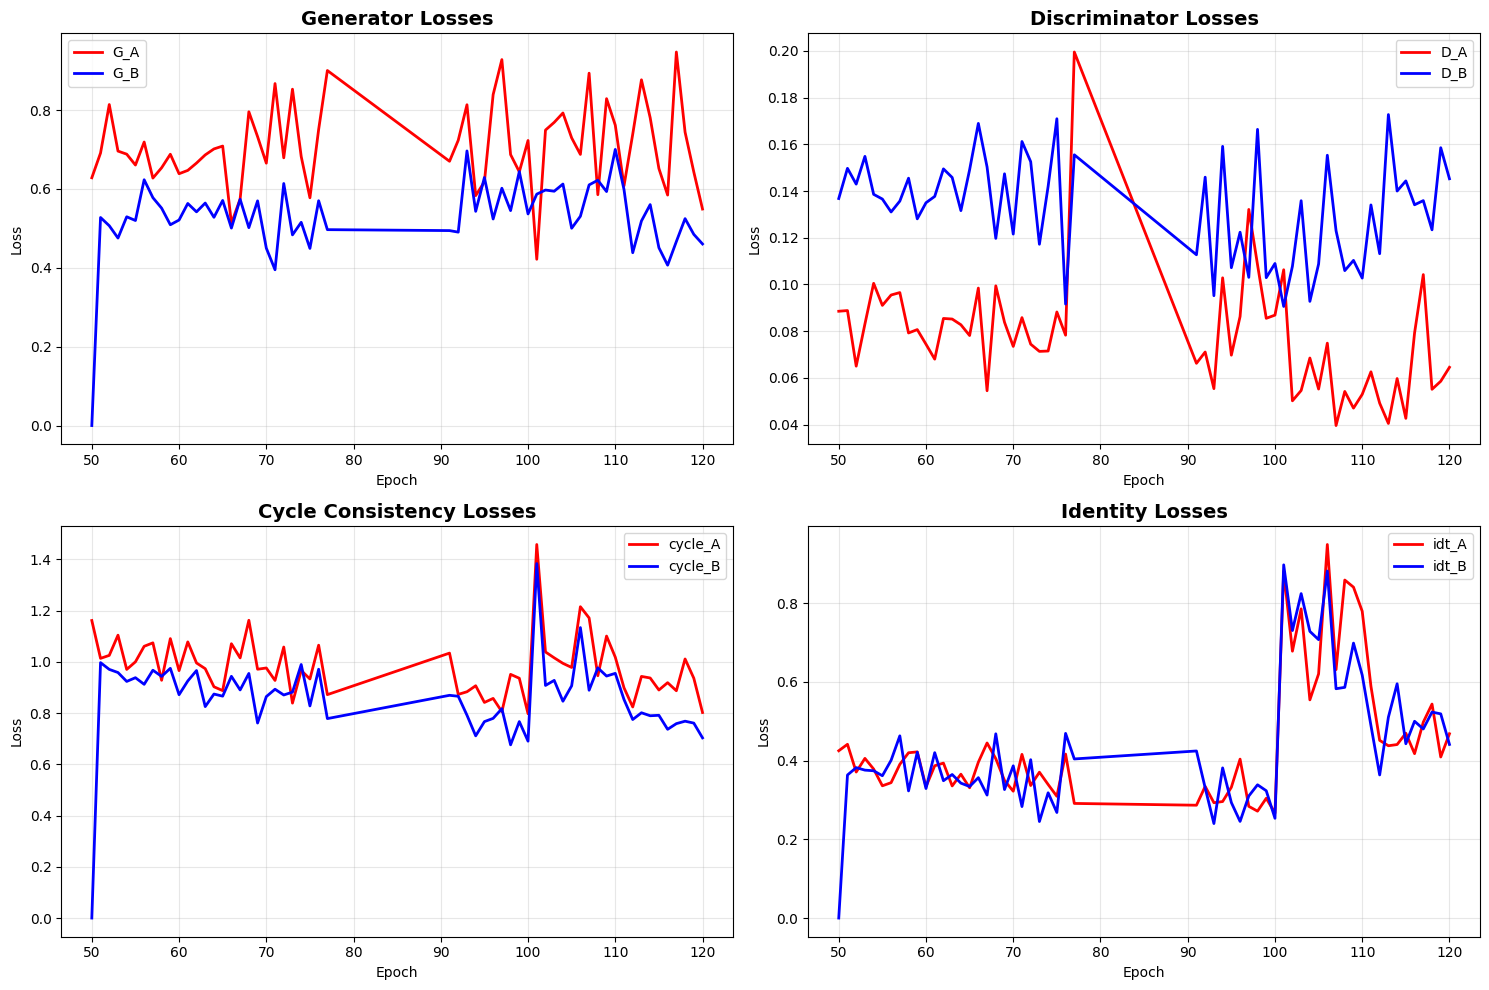

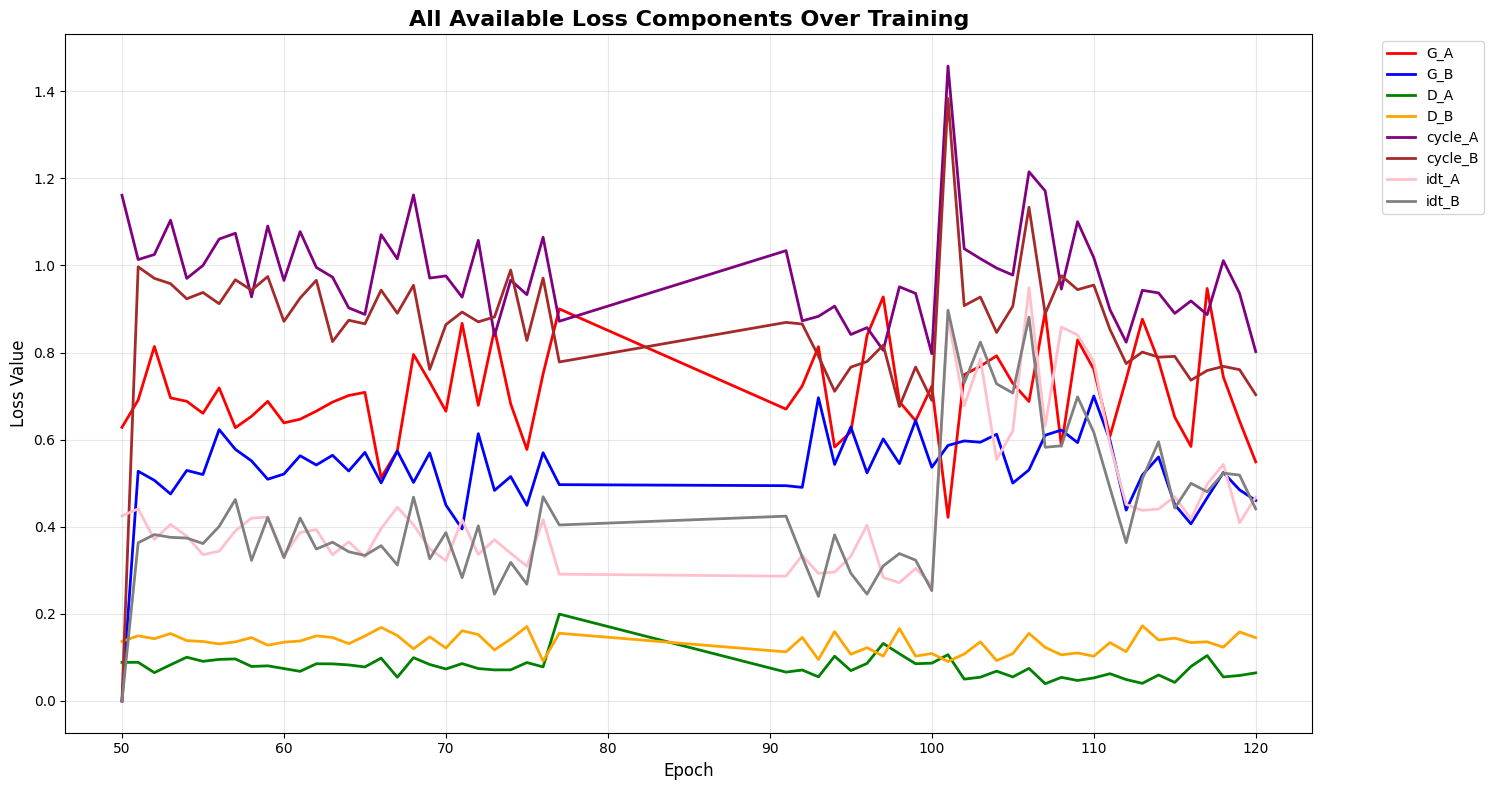


TRAINING LOSS SUMMARY
         G_A: Final=0.5490, Min=0.4216, Max=0.9471, Avg=0.7081
         G_B: Final=0.4604, Min=0.3950, Max=0.7001, Avg=0.5402
         D_A: Final=0.0645, Min=0.0396, Max=0.1995, Avg=0.0777
         D_B: Final=0.1452, Min=0.0906, Max=0.1727, Avg=0.1329
     cycle_A: Final=0.8021, Min=0.7973, Max=1.4578, Avg=0.9819
     cycle_B: Final=0.7032, Min=0.6760, Max=1.3834, Avg=0.8750
       idt_A: Final=0.4681, Min=0.2666, Max=0.9488, Avg=0.4456
       idt_B: Final=0.4410, Min=0.2400, Max=0.8971, Avg=0.4403


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Path to your log file
log_path = '/content/drive/MyDrive/finalProject_logs/loss_log.txt'

# Function to parse the log file with better error handling
def parse_log_robust(file_path):
    epochs = []
    losses = {'G_A': [], 'G_B': [], 'D_A': [], 'D_B': [],
             'cycle_A': [], 'cycle_B': [], 'idt_A': [], 'idt_B': []}

    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        print(f"Total lines in log file: {len(lines)}")

        # Check first few lines to understand format
        print("First 5 lines of log file:")
        for i, line in enumerate(lines[:5]):
            print(f"Line {i+1}: {line.strip()}")

        epoch_data = {}  # Dictionary to store all data for each epoch

        for line_num, line in enumerate(lines):
            line = line.strip()
            if not line or line.startswith('#') or ',' not in line:
                continue

            parts = line.split(',')
            if len(parts) < 5:  # Need at least epoch, iteration, and some losses
                continue

            try:
                epoch = int(float(parts[0]))
                iteration = int(float(parts[1]))

                # Initialize epoch if not seen before
                if epoch not in epoch_data:
                    epoch_data[epoch] = {'G_A': [], 'G_B': [], 'D_A': [], 'D_B': [],
                                        'cycle_A': [], 'cycle_B': [], 'idt_A': [], 'idt_B': []}

                # Parse loss values (skip epoch and iteration)
                loss_values = []
                for part in parts[2:]:
                    try:
                        val = float(part)
                        loss_values.append(val)
                    except:
                        continue

                # Map values based on your log format
                # Typical CycleGAN log format: epoch,iter,G_A,G_L1,cycle_A,idt_A,D_A,D_B,G_B,cycle_B,idt_B
                if len(loss_values) >= 6:
                    epoch_data[epoch]['G_A'].append(loss_values[0])  # G_A
                    # Skip G_L1 (loss_values[1])
                    epoch_data[epoch]['cycle_A'].append(loss_values[2])  # cycle_A
                    epoch_data[epoch]['idt_A'].append(loss_values[3])    # idt_A
                    epoch_data[epoch]['D_A'].append(loss_values[4])     # D_A
                    epoch_data[epoch]['D_B'].append(loss_values[5])     # D_B

                    if len(loss_values) >= 9:
                        epoch_data[epoch]['G_B'].append(loss_values[6])     # G_B
                        epoch_data[epoch]['cycle_B'].append(loss_values[7]) # cycle_B
                        epoch_data[epoch]['idt_B'].append(loss_values[8])   # idt_B

            except Exception as e:
                if line_num < 10:  # Only print errors for first 10 lines
                    print(f"Error parsing line {line_num+1}: {e}")
                continue

        # Calculate averages for each epoch
        for epoch in sorted(epoch_data.keys()):
            epochs.append(epoch)
            for loss_type in losses.keys():
                if epoch_data[epoch][loss_type]:
                    avg_loss = np.mean(epoch_data[epoch][loss_type])
                    losses[loss_type].append(avg_loss)
                else:
                    losses[loss_type].append(0.0)  # Default to 0 if no data

        print(f"Successfully parsed {len(epochs)} epochs")
        print(f"Epoch range: {min(epochs)} to {max(epochs)}")

        # Check data availability
        for loss_type, values in losses.items():
            non_zero_count = sum(1 for v in values if v > 0)
            print(f"{loss_type}: {non_zero_count}/{len(values)} epochs have data")

    except Exception as e:
        print(f"Error reading log file: {e}")

    return epochs, losses

# Parse the log with robust method
print("Parsing log file...")
epochs, losses = parse_log_robust(log_path)

# Create plots only if we have data
if epochs and len(epochs) > 0:
    # Filter out loss types with no data
    valid_losses = {k: v for k, v in losses.items() if any(val > 0 for val in v)}

    print(f"Creating plots for {len(valid_losses)} loss types...")

    # Determine subplot layout based on available data
    if len(valid_losses) >= 4:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
    else:
        fig, axes = plt.subplots(1, len(valid_losses), figsize=(5*len(valid_losses), 5))
        if len(valid_losses) == 1:
            axes = [axes]

    plot_idx = 0

    # Generator losses
    gen_losses = {k: v for k, v in valid_losses.items() if k.startswith('G_')}
    if gen_losses:
        ax = axes[plot_idx] if plot_idx < len(axes) else plt.subplot(2, 2, 1)
        for loss_name, loss_values in gen_losses.items():
            color = 'red' if 'A' in loss_name else 'blue'
            ax.plot(epochs, loss_values, color=color, label=loss_name, linewidth=2)
        ax.set_title('Generator Losses', fontsize=14, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plot_idx += 1

    # Discriminator losses
    disc_losses = {k: v for k, v in valid_losses.items() if k.startswith('D_')}
    if disc_losses:
        ax = axes[plot_idx] if plot_idx < len(axes) else plt.subplot(2, 2, 2)
        for loss_name, loss_values in disc_losses.items():
            color = 'red' if 'A' in loss_name else 'blue'
            ax.plot(epochs, loss_values, color=color, label=loss_name, linewidth=2)
        ax.set_title('Discriminator Losses', fontsize=14, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plot_idx += 1

    # Cycle consistency losses
    cycle_losses = {k: v for k, v in valid_losses.items() if k.startswith('cycle_')}
    if cycle_losses:
        ax = axes[plot_idx] if plot_idx < len(axes) else plt.subplot(2, 2, 3)
        for loss_name, loss_values in cycle_losses.items():
            color = 'red' if 'A' in loss_name else 'blue'
            ax.plot(epochs, loss_values, color=color, label=loss_name, linewidth=2)
        ax.set_title('Cycle Consistency Losses', fontsize=14, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plot_idx += 1

    # Identity losses
    idt_losses = {k: v for k, v in valid_losses.items() if k.startswith('idt_')}
    if idt_losses:
        ax = axes[plot_idx] if plot_idx < len(axes) else plt.subplot(2, 2, 4)
        for loss_name, loss_values in idt_losses.items():
            color = 'red' if 'A' in loss_name else 'blue'
            ax.plot(epochs, loss_values, color=color, label=loss_name, linewidth=2)
        ax.set_title('Identity Losses', fontsize=14, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plot_idx += 1

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/finalProject_epoch_outputs/loss_summary_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create a combined plot with all available losses
    plt.figure(figsize=(15, 8))
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    for i, (loss_name, loss_values) in enumerate(valid_losses.items()):
        color = colors[i % len(colors)]
        plt.plot(epochs, loss_values, color=color, label=loss_name, linewidth=2)

    plt.title('All Available Loss Components Over Training', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss Value', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/finalProject_epoch_outputs/all_losses_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary statistics
    print("\n" + "="*60)
    print("TRAINING LOSS SUMMARY")
    print("="*60)
    for loss_name, loss_values in valid_losses.items():
        if any(v > 0 for v in loss_values):
            valid_values = [v for v in loss_values if v > 0]
            print(f"{loss_name:>12}: Final={valid_values[-1]:.4f}, " +
                  f"Min={min(valid_values):.4f}, Max={max(valid_values):.4f}, " +
                  f"Avg={np.mean(valid_values):.4f}")

else:
    print("❌ No valid data found in the log file")
    print("Please check:")
    print("1. Log file path is correct")
    print("2. Log file contains comma-separated values")
    print("3. Log file has the expected format: epoch,iteration,loss1,loss2,...")

Mounted at /content/drive
COMPREHENSIVE TRAINING LOSS ANALYSIS
Found log file: /content/drive/MyDrive/finalProject_logs/loss_log.txt
  - File has 1036 lines
Loaded 907 log entries from 1 files
Epoch range: 50 to 120

This suggests either:
1. Earlier training logs are in a different file
2. Training was started from a checkpoint
3. Logs from epochs 1-49 were not saved or are in another location

Analyzing epochs 50 to 120

NOTE: Training data starts from epoch 50
Showing available data...

Early Training Progress (Epochs 50-99):

LOSS VALUES BY EPOCH (50 to 99):
Epoch    G_A      G_B      D_A      D_B      Cycle_A  Cycle_B  Idt_A    Idt_B    G/D_Bal 
------------------------------------------------------------------------------------------------------------------------
50       0.6282   0.0000   0.0885   0.1368   1.1612   0.0000   0.4249   0.0000   2.79    
51       0.6910   0.5275   0.0888   0.1497   1.0135   0.9968   0.4413   0.3633   5.11    
52       0.8139   0.5067   0.0650   0.143

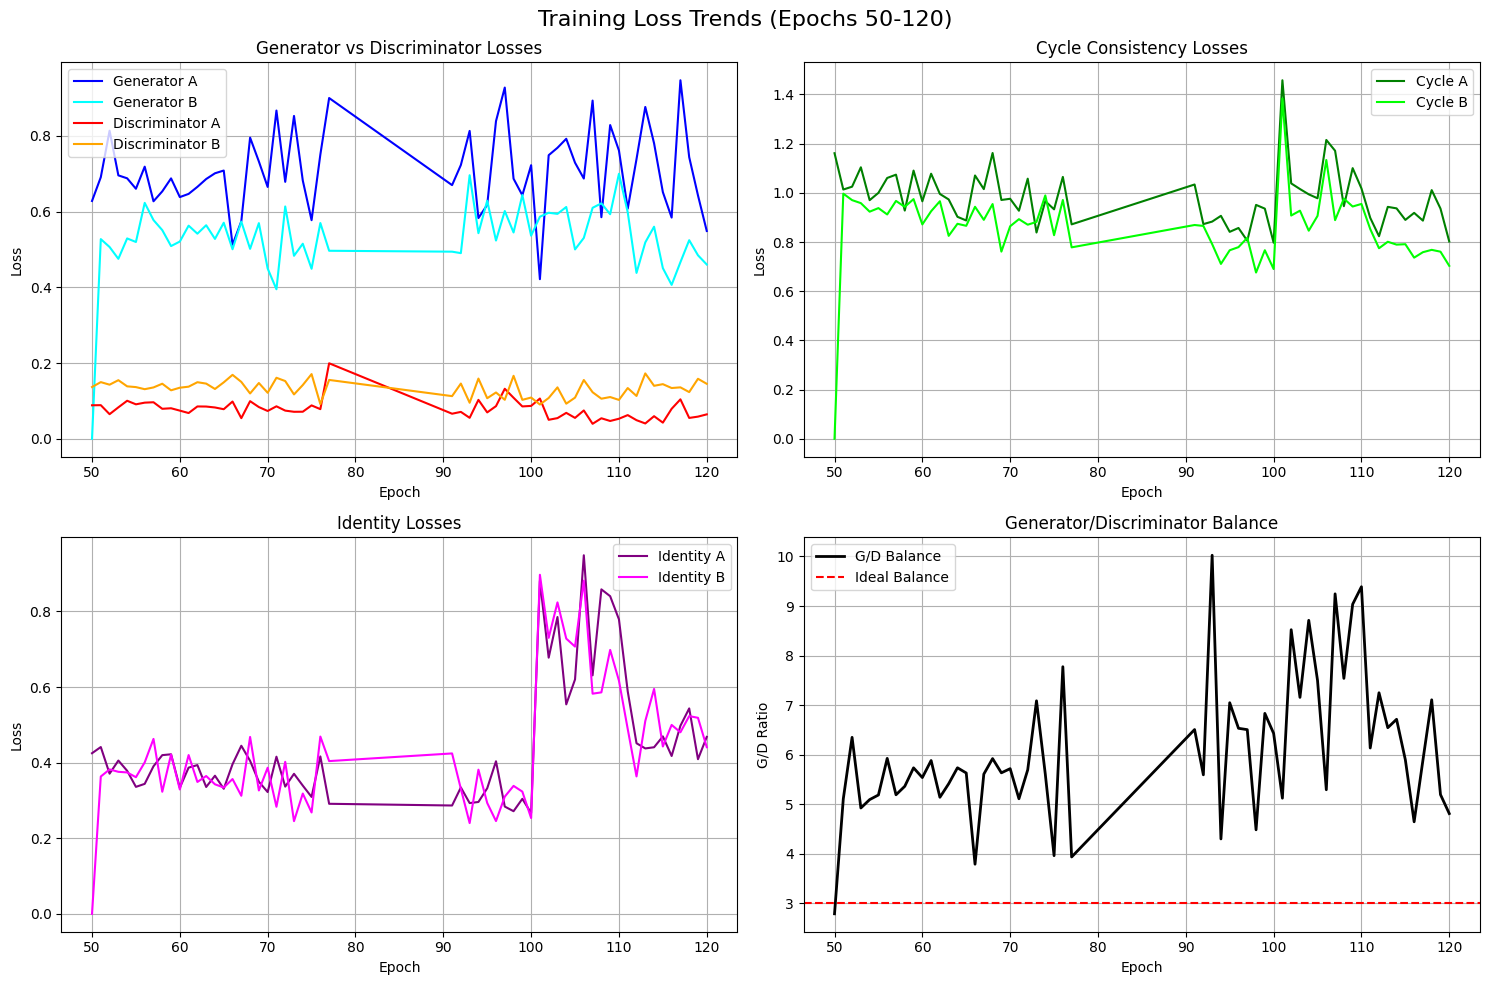


BEST PERFORMING EPOCHS:
Best Cycle Loss: Epoch 50 (loss: 1.1612)
Best Identity Loss: Epoch 50 (loss: 0.4249)
Best G/D Balance: Epoch 50 (ratio: 2.79)
Recent Best Cycle: Epoch 120 (loss: 1.5053)


In [ ]:
# Analyze training loss values from your existing logs
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

def read_loss_logs():
    """Read and parse all available loss log files"""

    # Check for log files in different locations and names
    log_paths = [
        '/content/drive/MyDrive/finalProject_logs/loss_log.txt',
        '/content/drive/MyDrive/finalProject_logs/training_log.txt',
        '/content/drive/MyDrive/finalProject_logs/complete_loss_log.txt',
        '/content/drive/MyDrive/finalProject_logs/loss_log_full.txt',
        '/content/drive/MyDrive/finalProject_checkpoints/loss_log.txt',
        '/content/backup_logs/loss_log.txt',
        '/content/loss_log.txt',
        # Check for any other log files in the directory
    ]

    # Also search for any files with "loss" or "log" in the name
    try:
        import glob
        additional_logs = []
        for pattern in ['/content/drive/MyDrive/**/loss*.txt', '/content/drive/MyDrive/**/training*.txt',
                       '/content/drive/MyDrive/**/*log*.txt']:
            additional_logs.extend(glob.glob(pattern, recursive=True))
        log_paths.extend(additional_logs)

        # Remove duplicates
        log_paths = list(set(log_paths))
    except:
        pass

    log_data = []

    for log_path in log_paths:
        if os.path.exists(log_path):
            print(f"Found log file: {log_path}")
            try:
                with open(log_path, 'r') as f:
                    lines = f.readlines()

                print(f"  - File has {len(lines)} lines")

                for line_num, line in enumerate(lines):
                    line = line.strip()
                    # Skip comments and empty lines
                    if line.startswith('#') or not line or 'epoch,iter' in line.lower():
                        continue

                    # Parse CSV-style log lines
                    try:
                        parts = line.split(',')
                        if len(parts) >= 6:  # Minimum expected columns
                            epoch = int(parts[0])
                            iter_num = int(parts[1])

                            # Handle different log formats
                            if len(parts) >= 10:  # Full format with all losses
                                loss_dict = {
                                    'epoch': epoch,
                                    'iter': iter_num,
                                    'G_A': float(parts[2]),
                                    'G_L1': float(parts[3]) if len(parts) > 3 else 0,
                                    'cycle_A': float(parts[4]) if len(parts) > 4 else 0,
                                    'idt_A': float(parts[5]) if len(parts) > 5 else 0,
                                    'D_A': float(parts[6]) if len(parts) > 6 else 0,
                                    'D_B': float(parts[7]) if len(parts) > 7 else 0,
                                    'G_B': float(parts[8]) if len(parts) > 8 else 0,
                                    'cycle_B': float(parts[9]) if len(parts) > 9 else 0,
                                    'idt_B': float(parts[10]) if len(parts) > 10 else 0
                                }
                            else:  # Simpler format with fewer columns
                                loss_dict = {
                                    'epoch': epoch,
                                    'iter': iter_num,
                                    'G_A': float(parts[2]),
                                    'G_L1': float(parts[3]) if len(parts) > 3 else 0,
                                    'cycle_A': float(parts[4]) if len(parts) > 4 else 0,
                                    'idt_A': float(parts[5]) if len(parts) > 5 else 0,
                                    'D_A': float(parts[6]) if len(parts) > 6 else 0,
                                    'D_B': float(parts[7]) if len(parts) > 7 else 0,
                                    'G_B': 0,
                                    'cycle_B': 0,
                                    'idt_B': 0
                                }

                            log_data.append(loss_dict)
                    except (ValueError, IndexError) as e:
                        # Print problematic lines for debugging
                        if line_num < 10:  # Only show first few problematic lines
                            print(f"  - Skipping line {line_num}: {line[:100]}...")
                        continue

            except Exception as e:
                print(f"Error reading {log_path}: {e}")
                continue

    if not log_data:
        print("No valid log data found!")
        print("\nTrying to find your original training logs...")

        # Search more broadly for any text files that might contain training data
        search_paths = [
            '/content/drive/MyDrive/',
            '/content/drive/MyDrive/finalProject*/',
            '/content/',
        ]

        for search_path in search_paths:
            if os.path.exists(search_path):
                try:
                    all_files = []
                    for root, dirs, files in os.walk(search_path):
                        for file in files:
                            if file.endswith('.txt') and ('log' in file.lower() or 'loss' in file.lower() or 'train' in file.lower()):
                                all_files.append(os.path.join(root, file))

                    if all_files:
                        print(f"\nFound potential log files in {search_path}:")
                        for f in all_files[:10]:  # Show first 10
                            print(f"  - {f}")
                        if len(all_files) > 10:
                            print(f"  ... and {len(all_files)-10} more files")
                except:
                    pass

        return None

    # Convert to DataFrame
    df = pd.DataFrame(log_data)
    print(f"Loaded {len(df)} log entries from {len([p for p in log_paths if os.path.exists(p)])} files")

    # Check epoch range
    if not df.empty:
        min_epoch = df['epoch'].min()
        max_epoch = df['epoch'].max()
        print(f"Epoch range: {min_epoch} to {max_epoch}")

        if min_epoch > 1:
            print(f"\nWARNING: Log data starts from epoch {min_epoch}, not epoch 1")
            print("This suggests either:")
            print("1. Earlier training logs are in a different file")
            print("2. Training was started from a checkpoint")
            print("3. Logs from epochs 1-{} were not saved or are in another location".format(min_epoch-1))

    return df

def analyze_losses_by_epoch(df):
    """Analyze losses grouped by epoch"""

    if df is None or df.empty:
        print("No data to analyze")
        return

    # Group by epoch and calculate averages
    epoch_stats = df.groupby('epoch').agg({
        'G_A': ['mean', 'std', 'min', 'max'],
        'G_B': ['mean', 'std', 'min', 'max'],
        'D_A': ['mean', 'std', 'min', 'max'],
        'D_B': ['mean', 'std', 'min', 'max'],
        'cycle_A': ['mean', 'std', 'min', 'max'],
        'cycle_B': ['mean', 'std', 'min', 'max'],
        'idt_A': ['mean', 'std', 'min', 'max'],
        'idt_B': ['mean', 'std', 'min', 'max']
    }).round(4)

    # Flatten column names
    epoch_stats.columns = ['_'.join(col).strip() for col in epoch_stats.columns.values]

    return epoch_stats

def display_epoch_losses(df, start_epoch=1, end_epoch=None):
    """Display loss values for specific epoch range"""

    if df is None or df.empty:
        print("No data to display")
        return

    # Filter by epoch range
    if end_epoch is None:
        end_epoch = df['epoch'].max()

    epoch_range = df[(df['epoch'] >= start_epoch) & (df['epoch'] <= end_epoch)]

    if epoch_range.empty:
        print(f"No data found for epochs {start_epoch}-{end_epoch}")
        return

    # Calculate epoch averages
    epoch_avg = epoch_range.groupby('epoch').agg({
        'G_A': 'mean',
        'G_B': 'mean',
        'D_A': 'mean',
        'D_B': 'mean',
        'cycle_A': 'mean',
        'cycle_B': 'mean',
        'idt_A': 'mean',
        'idt_B': 'mean'
    }).round(4)

    print(f"\nLOSS VALUES BY EPOCH ({start_epoch} to {end_epoch}):")
    print("=" * 120)

    # Header
    print(f"{'Epoch':<8} {'G_A':<8} {'G_B':<8} {'D_A':<8} {'D_B':<8} {'Cycle_A':<8} {'Cycle_B':<8} {'Idt_A':<8} {'Idt_B':<8} {'G/D_Bal':<8}")
    print("-" * 120)

    # Display each epoch
    for epoch in sorted(epoch_avg.index):
        row = epoch_avg.loc[epoch]

        # Calculate G/D balance
        g_avg = (row['G_A'] + row['G_B']) / 2
        d_avg = (row['D_A'] + row['D_B']) / 2
        gd_balance = g_avg / d_avg if d_avg > 0 else float('inf')

        print(f"{epoch:<8} {row['G_A']:<8.4f} {row['G_B']:<8.4f} {row['D_A']:<8.4f} {row['D_B']:<8.4f} " +
              f"{row['cycle_A']:<8.4f} {row['cycle_B']:<8.4f} {row['idt_A']:<8.4f} {row['idt_B']:<8.4f} {gd_balance:<8.2f}")

def plot_loss_trends(df, start_epoch=1, end_epoch=None):
    """Plot loss trends over epochs"""

    if df is None or df.empty:
        print("No data to plot")
        return

    # Filter by epoch range
    if end_epoch is None:
        end_epoch = df['epoch'].max()

    epoch_range = df[(df['epoch'] >= start_epoch) & (df['epoch'] <= end_epoch)]

    if epoch_range.empty:
        print(f"No data found for epochs {start_epoch}-{end_epoch}")
        return

    # Calculate epoch averages
    epoch_avg = epoch_range.groupby('epoch').agg({
        'G_A': 'mean',
        'G_B': 'mean',
        'D_A': 'mean',
        'D_B': 'mean',
        'cycle_A': 'mean',
        'cycle_B': 'mean',
        'idt_A': 'mean',
        'idt_B': 'mean'
    })

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Training Loss Trends (Epochs {start_epoch}-{end_epoch})', fontsize=16)

    # Generator vs Discriminator losses
    axes[0,0].plot(epoch_avg.index, epoch_avg['G_A'], label='Generator A', color='blue')
    axes[0,0].plot(epoch_avg.index, epoch_avg['G_B'], label='Generator B', color='cyan')
    axes[0,0].plot(epoch_avg.index, epoch_avg['D_A'], label='Discriminator A', color='red')
    axes[0,0].plot(epoch_avg.index, epoch_avg['D_B'], label='Discriminator B', color='orange')
    axes[0,0].set_title('Generator vs Discriminator Losses')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Cycle losses
    axes[0,1].plot(epoch_avg.index, epoch_avg['cycle_A'], label='Cycle A', color='green')
    axes[0,1].plot(epoch_avg.index, epoch_avg['cycle_B'], label='Cycle B', color='lime')
    axes[0,1].set_title('Cycle Consistency Losses')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    axes[0,1].grid(True)

    # Identity losses
    axes[1,0].plot(epoch_avg.index, epoch_avg['idt_A'], label='Identity A', color='purple')
    axes[1,0].plot(epoch_avg.index, epoch_avg['idt_B'], label='Identity B', color='magenta')
    axes[1,0].set_title('Identity Losses')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Loss')
    axes[1,0].legend()
    axes[1,0].grid(True)

    # G/D Balance
    g_avg = (epoch_avg['G_A'] + epoch_avg['G_B']) / 2
    d_avg = (epoch_avg['D_A'] + epoch_avg['D_B']) / 2
    gd_balance = g_avg / d_avg

    axes[1,1].plot(epoch_avg.index, gd_balance, label='G/D Balance', color='black', linewidth=2)
    axes[1,1].axhline(y=3.0, color='red', linestyle='--', label='Ideal Balance')
    axes[1,1].set_title('Generator/Discriminator Balance')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('G/D Ratio')
    axes[1,1].legend()
    axes[1,1].grid(True)

    plt.tight_layout()
    plt.show()

def find_best_epochs(df):
    """Find epochs with best performance metrics"""

    if df is None or df.empty:
        print("No data to analyze")
        return

    # Calculate epoch averages
    epoch_avg = df.groupby('epoch').agg({
        'G_A': 'mean',
        'G_B': 'mean',
        'D_A': 'mean',
        'D_B': 'mean',
        'cycle_A': 'mean',
        'cycle_B': 'mean',
        'idt_A': 'mean',
        'idt_B': 'mean'
    })

    # Calculate metrics
    epoch_avg['total_cycle'] = epoch_avg['cycle_A'] + epoch_avg['cycle_B']
    epoch_avg['total_identity'] = epoch_avg['idt_A'] + epoch_avg['idt_B']
    epoch_avg['g_avg'] = (epoch_avg['G_A'] + epoch_avg['G_B']) / 2
    epoch_avg['d_avg'] = (epoch_avg['D_A'] + epoch_avg['D_B']) / 2
    epoch_avg['gd_balance'] = epoch_avg['g_avg'] / epoch_avg['d_avg']
    epoch_avg['gd_balance_score'] = abs(epoch_avg['gd_balance'] - 3.0)  # Closer to 3 is better

    print("\nBEST PERFORMING EPOCHS:")
    print("=" * 60)

    # Best cycle loss
    best_cycle_epoch = epoch_avg['total_cycle'].idxmin()
    print(f"Best Cycle Loss: Epoch {best_cycle_epoch} (loss: {epoch_avg.loc[best_cycle_epoch, 'total_cycle']:.4f})")

    # Best identity loss
    best_identity_epoch = epoch_avg['total_identity'].idxmin()
    print(f"Best Identity Loss: Epoch {best_identity_epoch} (loss: {epoch_avg.loc[best_identity_epoch, 'total_identity']:.4f})")

    # Best G/D balance
    best_balance_epoch = epoch_avg['gd_balance_score'].idxmin()
    print(f"Best G/D Balance: Epoch {best_balance_epoch} (ratio: {epoch_avg.loc[best_balance_epoch, 'gd_balance']:.2f})")

    # Recent best (last 20 epochs)
    recent_epochs = epoch_avg.tail(20)
    if not recent_epochs.empty:
        recent_best_cycle = recent_epochs['total_cycle'].idxmin()
        print(f"Recent Best Cycle: Epoch {recent_best_cycle} (loss: {recent_epochs.loc[recent_best_cycle, 'total_cycle']:.4f})")

# Main analysis
print("COMPREHENSIVE TRAINING LOSS ANALYSIS")
print("=" * 50)

# Read the log data
df = read_loss_logs()

if df is not None:
    min_epoch = df['epoch'].min()
    max_epoch = df['epoch'].max()

    print(f"\nAnalyzing epochs {min_epoch} to {max_epoch}")

    # If data doesn't start from epoch 1, show what we have
    if min_epoch > 1:
        print(f"\nNOTE: Training data starts from epoch {min_epoch}")
        print("Showing available data...")

    # Display loss values from the beginning of available data
    start_display = min_epoch
    end_display = min(min_epoch + 49, max_epoch)  # Show first 50 epochs of available data

    print(f"\nEarly Training Progress (Epochs {start_display}-{end_display}):")
    display_epoch_losses(df, start_epoch=start_display, end_epoch=end_display)

    # If we have later data, show recent progress too
    if max_epoch - min_epoch > 50:
        recent_start = max(min_epoch, max_epoch - 19)
        print(f"\nRecent Training Progress (Epochs {recent_start}-{max_epoch}):")
        display_epoch_losses(df, start_epoch=recent_start, end_epoch=max_epoch)

    # Plot trends for all available data
    print(f"\nGenerating loss trend plots for epochs {min_epoch}-{max_epoch}...")
    plot_loss_trends(df, start_epoch=min_epoch, end_epoch=max_epoch)

    # Find best epochs
    find_best_epochs(df)



8. Screenshots of how training progress on a specific image (10 images overall):

In [ ]:
import matplotlib.pyplot as plt
import glob
from PIL import Image
import numpy as np
import os

# Path to your test image outputs
outputs_dir = '/content/drive/MyDrive/finalProject_epoch_outputs/'

# Create a list of checkpoint epochs you want to display (ideally spread across training)
target_epochs = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Find available images
available_images = {}
for epoch in target_epochs:
    path = os.path.join(outputs_dir, f'epoch_{epoch}.png')
    if os.path.exists(path):
        available_images[epoch] = path

# Use only available epochs
available_epochs = sorted(list(available_images.keys()))

if len(available_epochs) >= 5:  # Need at least 5 for a good visualization
    # Create a grid of images showing progression
    num_images = len(available_epochs)
    rows = (num_images + 2) // 3  # About 3 images per row
    cols = min(3, num_images)

    plt.figure(figsize=(15, rows * 4))

    for i, epoch in enumerate(available_epochs):
        img = Image.open(available_images[epoch])
        plt.subplot(rows, cols, i+1)
        plt.imshow(np.array(img))
        plt.title(f'Epoch {epoch}')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(outputs_dir, 'training_progression.png'), dpi=300)
    plt.show()
else:
    print(f"Not enough images found. Available epochs: {available_epochs}")

Output hidden; open in https://colab.research.google.com to view.